
# <font color=blue>Predicting Incomes from US Census Bureau Data</font>
**The objective of this project is to model demographic and employment data to predict incomes. The data consists of census data extracted from the Current Population Surveys of 1994 and 1995, conducted by the US Census Bureau.**

### The project is structured along the following framework:
1. **Business Understanding**
2. **Data Understanding**
3. **Data Preparation**
4. **Model Construction**
5. **Model Evaluation**
6. **Model Deployment**
7. **Business Insights**
8. **Conclusions**

# <font color=blue>1. Business Understanding</font>
## Business Objective
The business objective behind this project can be analysed from three different perspective. That of the US Census Bureau conducting the surveys, that of governments and institutional actors, and that of the private sector:
* **For the Census Bureau:**
    * An accurate prediction model of incomes can help them predict subjects' incomes in areas where they don't have actual data on incomes.
    * This can enhance the quality of the data for areas where data is sparse or methodologically questionable.
    * It can also significantly reduce for them the cost of data collection, both economic and in terms of manpower.
* **Governments and  institutional actors:**
    * Income is an important indicator for economic and social markers, such as quality of nutrition, access to medical services and utilities, etc.
    * Having more and better insights into income levels of populations can guide better policy design.
* **Private sector:**
    * Income levels tend to have a strong association to disposable income and purchasing power of groups and individuals.
    * Understanding income levels across segments and areas helps companies improve location selection, optimise supply chains, design better pricing strategies, among others.

## Business Success Criteria
The business success criteria for the Census Beureau deriving from this project is defined as follows:
* Increase in accuracy of projections of incomes in the US from one census period to the next. 
* Less estimation errors in modelling year-on-year changes in incomes predictions and associated demographic data between census periods.

## Project Plan
<img src="resources/US_Census_Data.png">

In [428]:
##### INSTALL ALL PROJECT'S DEPENDENCIES #####
library(stringr)
library(Hmisc)
library(plyr)
library(gridExtra)
library(dplyr)
library(arsenal)
library(VIM)
library(InformationValue)
library(caret)
library(gbm)
library(DMwR)
library(pROC)
library(e1071)
library(corrplot)

# <font color=blue>2. Data Understanding</font>
In order to understand the data, this section consists of two tasks:
1. Survey the metadata for the dataset, and structure it into a data frame.
2. Survey the dataset and verify it matches with the metadata.

# Surveying the  Metadata
Metadata for the dataset was unstructured in text format. This section of the code collects the different elements of the metadata in the text file and structures them into a data frame holding each variables name, ID, type, number of distinct values, and factor levels for categorical values.

In [429]:
##### READ IN METADATA FILE #####
metadata_file <- readLines("data/census_income_metadata.txt")

In [430]:
##### GET VARIABLES' DESCRIPTIONS AND ID #####
clean_variables_description <- function(line){
  out <- str_sub(string = line, start = 2)
  out <- trimws(out)
  out <- str_split(string = out, pattern = "\t+")
  return(out)
}
var_names <- metadata_file[24:68]
var_names_list <- lapply(var_names, clean_variables_description)
var_names_df <- data.frame(matrix(unlist(var_names_list), nrow = 45, byrow = TRUE), stringsAsFactors = FALSE)
names(var_names_df) <- c("var_description", "var_ID")

In [431]:
##### GET VARIABLES' TYPE AND NUMBER OF DISTINCT VALUES #####
clean_variables_types <- function(line){
  out <- str_sub(string = line, start = 2)
  out <- str_split(string = out, pattern = " (?=distinct)|\\(|\\)", simplify = TRUE)
  out <- out[c(1,length(out)-1,length(out))]
  out <- trimws(out)
  return(out)
}
var_types <- metadata_file[82:121]
var_types_list <- lapply(var_types, clean_variables_types)
var_types_df <- data.frame(matrix(unlist(var_types_list), nrow = 40, byrow = TRUE), stringsAsFactors = FALSE)
names(var_types_df) <- c("num_distinct_vals", "var_description", "var_type")

In [432]:
##### GET VARIABLES' DISTINCT VALUES #####
clean_unique_values <- function(line){
  out <- str_sub(string = line, start = 1, end = nchar(line) - 1)
  out <- gsub(pattern = "\\|", replacement = "", x = out)
  out <- str_split(string = out, pattern = ":", n = 2, simplify = TRUE)
  out <- trimws(out)
  return(out)
}
var_unique_vals <- metadata_file[143:184]
var_unique_vals_list <- lapply(var_unique_vals, clean_unique_values)
var_unique_vals_df <- data.frame(matrix(unlist(var_unique_vals_list), nrow = 42, byrow = TRUE), stringsAsFactors = FALSE)
names(var_unique_vals_df) <- c("var_description", "var_factors")

In [433]:
##### NORMALISE AND CLEAN VARIABLE NAMES #####
var_names_df$var_description[var_names_df$var_description == "industry code"] <- "detailed industry recode"
var_names_df$var_description[var_names_df$var_description == "occupation code"] <- "detailed occupation recode"
var_names_df$var_description[var_names_df$var_description == "enrolled in edu inst last wk"] <- "enroll in edu inst last wk"
var_names_df$var_description[var_names_df$var_description == "marital status"] <- "marital stat"
var_names_df$var_description[var_names_df$var_description == "mace"] <- "race"
var_names_df$var_description[var_names_df$var_description == "hispanic Origin"] <- "hispanic origin"
var_names_df$var_description[var_names_df$var_description == "divdends from stocks"] <- "dividends from stocks"
var_names_df$var_description[var_names_df$var_description == "tax filer status"] <- "tax filer stat"
var_names_df <- rbind(var_names_df, c("year", "YEAR"))

excluded <- c("adjusted gross income", "federal income tax liability", "total person earnings", "total person income", "taxable income amount")
var_names_df <- var_names_df[!var_names_df$var_description %in% excluded, ]

In [434]:
##### JOIN VARIABLE METADATA #####
metadata_df <- left_join(var_names_df, var_types_df, by = "var_description") %>%
  left_join(., var_unique_vals_df, by = "var_description")

metadata_df <- metadata_df[-25, ]
metadata_df$var_description[metadata_df$var_description == "fill inc questionnaire for veteran's admin"] <- "fill inc questionnaire for veterans admin"
metadata_df$var_description <- str_replace_all(string = metadata_df$var_description, pattern = " ", replacement = "_")

In [435]:
##### SAVE METADATA DATAFRAME ##### 
#saveRDS(object = metadata_df, file = "resources/metadata_df.RDS")
head(metadata_df)

var_description,var_ID,num_distinct_vals,var_type,var_factors
age,AAGE,91,continuous,continuous
class_of_worker,ACLSWKR,9,nominal,"Not in universe, Federal government, Local government, Never worked, Private, Self-employed-incorporated, Self-employed-not incorporated, State government, Without pay"
detailed_industry_recode,ADTIND,52,nominal,"0, 40, 44, 2, 43, 47, 48, 1, 11, 19, 24, 25, 32, 33, 34, 35, 36, 37, 38, 39, 4, 42, 45, 5, 15, 16, 22, 29, 31, 50, 14, 17, 18, 28, 3, 30, 41, 46, 51, 12, 13, 21, 23, 26, 6, 7, 9, 49, 27, 8, 10, 20"
detailed_occupation_recode,ADTOCC,47,nominal,"0, 12, 31, 44, 19, 32, 10, 23, 26, 28, 29, 42, 40, 34, 14, 36, 38, 2, 20, 25, 37, 41, 27, 24, 30, 43, 33, 16, 45, 17, 35, 22, 18, 39, 3, 15, 13, 46, 8, 21, 9, 4, 6, 5, 1, 11, 7"
education,AHGA,17,nominal,"Children, 7th and 8th grade, 9th grade, 10th grade, High school graduate, 11th grade, 12th grade no diploma, 5th or 6th grade, Less than 1st grade, Bachelors degree(BA AB BS), 1st 2nd 3rd or 4th grade, Some college but no degree, Masters degree(MA MS MEng MEd MSW MBA), Associates degree-occup /vocational, Associates degree-academic program, Doctorate degree(PhD EdD), Prof school degree (MD DDS DVM LLB JD)"
wage_per_hour,AHRSPAY,1240,continuous,continuous


In [436]:
##### GOOD HOUSEKEEPING #####
rm(var_types, var_types_list)
rm(var_names, var_names_list)
rm(var_unique_vals, var_unique_vals_list, metadata_file)
rm(excluded)
rm(var_names_df, var_types_df, var_unique_vals_df)

# Surveying the Training Data
The training and test data sets were headerless in a csv file. This section validates that the variables, names, types, number of distinct values, and factor levels in the data sets match the metadata supplied in the text file.

In [437]:
##### READ IN TRAIN SET #####
train_data <- read.csv(file = "data/census_income_learn.csv")

In [438]:
##### ASSIGN VARIABLE NAMES TO TRAIN SET #####
names(train_data) <- c(metadata_df$var_description, "income")

In [439]:
##### FUNCTION FOR GETTING DISTINCT VALUES #####
check_sanity_distinct <- function(var_name){
  vals <- trimws(as.character(train_data[,names(train_data) == var_name]))
  unique_vals <- sort(unique(vals))
  num_unique_vals <- length(unique_vals)
  unique_vals <- unique_vals[unique_vals != "?"]
  unique_vals <- paste(unique_vals, collapse = ", ")
  out <- list(var_name = var_name, sc_unique_vals = unique_vals, sc_num_unique_vals = num_unique_vals)
  return(out)
}

In [440]:
##### GET UNIQUE VALUES FROM LEARNING FILE (TRAINING DATA) #####
sc_uniques <- lapply(names(train_data)[!names(train_data) %in% c("income")], check_sanity_distinct)
sc_var_description <- unlist(lapply(sc_uniques, function(x) x[[1]]))
sc_unique_vals <- unlist(lapply(sc_uniques, function(x) x[[2]]))
sc_num_unique_vals <- unlist(lapply(sc_uniques, function(x) x[[3]]))    

In [441]:
##### CHECK VAR DESCRIPTIONS #####
metadata_df$sc_var_description <- sc_var_description
metadata_df$sc_var_description_bool <- metadata_df$var_description == metadata_df$sc_var_description

In [442]:
##### CHECK NUMBER OF UNIQUE VALUES #####
metadata_df$sc_num_unique_vals <- sc_num_unique_vals
metadata_df$sc_num_unique_vals_bool <- metadata_df$num_distinct_vals == metadata_df$sc_num_unique_vals

In [443]:
##### FUNCTION FOR CHECKING UNIQUE VALUES #####
compare_vector_elements <- function(string_1, string_2){
  vec_1 <- trimws(unlist(str_split(string = string_1, pattern = ",")))
  vec_2 <- trimws(unlist(str_split(string = string_2, pattern = ",")))
  equality_check <- identical(sort(vec_1), sort(vec_2))
  return(equality_check)
}

In [444]:
##### CHECK UNIQUE VALUES #####
metadata_df$sc_unique_vals <- sc_unique_vals
metadata_df$sc_unique_vals[metadata_df$var_factors == "continuous"] <- "continuous"
metadata_df$sc_unique_vals_bool <- mapply(compare_vector_elements, metadata_df$var_factors, metadata_df$sc_unique_vals)

In [445]:
##### VALIDATE METADATA VIS-A-VIS TRAINING DATA #####
#saveRDS(object = metadata_df, file = "resources/metadata_df_sanity_check_training_set.RDS")
head(metadata_df)

var_description,var_ID,num_distinct_vals,var_type,var_factors,sc_var_description,sc_var_description_bool,sc_num_unique_vals,sc_num_unique_vals_bool,sc_unique_vals,sc_unique_vals_bool
age,AAGE,91,continuous,continuous,age,TRUE,91,TRUE,continuous,TRUE
class_of_worker,ACLSWKR,9,nominal,"Not in universe, Federal government, Local government, Never worked, Private, Self-employed-incorporated, Self-employed-not incorporated, State government, Without pay",class_of_worker,TRUE,9,TRUE,"Federal government, Local government, Never worked, Not in universe, Private, Self-employed-incorporated, Self-employed-not incorporated, State government, Without pay",TRUE
detailed_industry_recode,ADTIND,52,nominal,"0, 40, 44, 2, 43, 47, 48, 1, 11, 19, 24, 25, 32, 33, 34, 35, 36, 37, 38, 39, 4, 42, 45, 5, 15, 16, 22, 29, 31, 50, 14, 17, 18, 28, 3, 30, 41, 46, 51, 12, 13, 21, 23, 26, 6, 7, 9, 49, 27, 8, 10, 20",detailed_industry_recode,TRUE,52,TRUE,"0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 6, 7, 8, 9",TRUE
detailed_occupation_recode,ADTOCC,47,nominal,"0, 12, 31, 44, 19, 32, 10, 23, 26, 28, 29, 42, 40, 34, 14, 36, 38, 2, 20, 25, 37, 41, 27, 24, 30, 43, 33, 16, 45, 17, 35, 22, 18, 39, 3, 15, 13, 46, 8, 21, 9, 4, 6, 5, 1, 11, 7",detailed_occupation_recode,TRUE,47,TRUE,"0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 5, 6, 7, 8, 9",TRUE
education,AHGA,17,nominal,"Children, 7th and 8th grade, 9th grade, 10th grade, High school graduate, 11th grade, 12th grade no diploma, 5th or 6th grade, Less than 1st grade, Bachelors degree(BA AB BS), 1st 2nd 3rd or 4th grade, Some college but no degree, Masters degree(MA MS MEng MEd MSW MBA), Associates degree-occup /vocational, Associates degree-academic program, Doctorate degree(PhD EdD), Prof school degree (MD DDS DVM LLB JD)",education,TRUE,17,TRUE,"10th grade, 11th grade, 12th grade no diploma, 1st 2nd 3rd or 4th grade, 5th or 6th grade, 7th and 8th grade, 9th grade, Associates degree-academic program, Associates degree-occup /vocational, Bachelors degree(BA AB BS), Children, Doctorate degree(PhD EdD), High school graduate, Less than 1st grade, Masters degree(MA MS MEng MEd MSW MBA), Prof school degree (MD DDS DVM LLB JD), Some college but no degree",TRUE
wage_per_hour,AHRSPAY,1240,continuous,continuous,wage_per_hour,TRUE,1240,TRUE,continuous,TRUE


In [446]:
##### GOOD HOUSEKEEPING #####
rm(list=setdiff(ls(), c("metadata_df", "compare_vector_elements")))
ls()

[1] "compare_vector_elements" "metadata_df"

# Surveying the Test Data

In [447]:
##### READ IN TEST SET #####
test_data <- read.csv(file = "data/census_income_test.csv")

In [448]:
##### ASSIGN VARIABLE NAMES TO TEST SET #####
names(test_data) <- c(metadata_df$var_description, "income")

In [449]:
##### FUNCTION FOR GETTING DISTINCT VALUES #####
check_sanity_distinct <- function(var_name){
  vals <- trimws(as.character(test_data[,names(test_data) == var_name]))
  unique_vals <- sort(unique(vals))
  num_unique_vals <- length(unique_vals)
  unique_vals <- unique_vals[unique_vals != "?"]
  unique_vals <- paste(unique_vals, collapse = ", ")
  out <- list(var_name = var_name, sc_unique_vals = unique_vals, sc_num_unique_vals = num_unique_vals)
  return(out)
}

In [450]:
##### GET UNIQUE VALUES FROM TEST DATA #####
sc_uniques <- lapply(names(test_data)[!names(test_data) %in% c("income")], check_sanity_distinct)
sc_var_description <- unlist(lapply(sc_uniques, function(x) x[[1]]))
sc_unique_vals <- unlist(lapply(sc_uniques, function(x) x[[2]]))
sc_num_unique_vals <- unlist(lapply(sc_uniques, function(x) x[[3]]))    

In [451]:
##### CHECK VAR DESCRIPTIONS #####
metadata_df$sc_var_description <- sc_var_description
metadata_df$sc_var_description_bool <- metadata_df$var_description == metadata_df$sc_var_description

In [452]:
##### CHECK NUMBER OF UNIQUE VALUES #####
metadata_df$sc_num_unique_vals <- sc_num_unique_vals
metadata_df$sc_num_unique_vals_bool <- metadata_df$num_distinct_vals == metadata_df$sc_num_unique_vals

In [453]:
##### CHECK UNIQUE VALUES #####
metadata_df$sc_unique_vals <- sc_unique_vals
metadata_df$sc_unique_vals[metadata_df$var_factors == "continuous"] <- "continuous"
metadata_df$sc_unique_vals_bool <- mapply(compare_vector_elements, metadata_df$var_factors, metadata_df$sc_unique_vals)

In [454]:
##### AUDIT NON-MATCHING UNIQUE VALUES #####
set_diff_vector_elements <- function(string_1, string_2){
  vec_1 <- trimws(unlist(str_split(string = string_1, pattern = ",")))
  vec_2 <- trimws(unlist(str_split(string = string_2, pattern = ",")))
  diffs <- setdiff(vec_1, vec_2)
  return(diffs)
}

In [455]:
# Create subset of observations from categorical variables with non-matching unique values:
audit_test_df <- metadata_df %>%
  filter(var_type != "continuous") %>%
  filter(sc_unique_vals_bool == FALSE)

In [456]:
# Identify which unique values for the relevant variable appears in the training set but not in the test set:
factors_not_in_test_set <- set_diff_vector_elements(audit_test_df$var_factors[1], audit_test_df$sc_unique_vals[1])
cat(factors_not_in_test_set)

Grandchild <18 ever marr not in subfamily

In [457]:
# Double check missing factors:
print(grep(pattern = factors_not_in_test_set, x = metadata_df$var_factors))        # [1] 23
print(grep(pattern = factors_not_in_test_set, x = metadata_df$sc_unique_vals))     # integer(0)

[1] 23
integer(0)


In [458]:
##### GOOD HOUSEKEEPING #####
rm(list=setdiff(ls(), c("metadata_df")))
ls()

[1] "metadata_df"

## <font color=green>SUMMARY</font>
* The dataset consists of 41 variables, separated in a training set of 199,522 observations and a test set of 99,761 observations.
* The only difference between the training set and the test set, is that the test set lacks a factor level that does appear in the training set: "Grandchild <18 ever marr not in subfamily" in variable "detailed household and family stat".
* A missing factor level in the test set is not problematic for the downstream processes planned in this project. The reverse could be problematic, i.e. a factor level that appears in the test set but not in the training set, but it is not the case here.

# <font color=blue>3. Data Preparation</font>
Data preparation in this project consists on the following tasks:
1. Building the data frames for data prepration.
2. Produce global summary statistics.
3. Exploratory data analysis.
4. Manual imputation of NA/NIU.
5. Recoding categorical variables.
6. Treatment of remaining missing values.

### 1. Building the data frames

In [459]:
##### READ IN TRAIN AND TEST SET #####
train_data <- read.csv(file = "data/census_income_learn.csv", header = FALSE)
test_data <- read.csv(file = "data/census_income_test.csv", header = FALSE)

In [460]:
##### ASSIGN VARIABLE NAMES TO TRAIN AND TEST SET #####
names(train_data) <- c(metadata_df$var_description, "income")
names(test_data) <- c(metadata_df$var_description, "income")
rm(metadata_df)

In [461]:
##### REMOVE COLUMNS NOT RELEVANT FOR EDA #####
# Instance Weight: 
# Criteria (from metadada file): "The instance weight indicates the number of people in the population that each record represents  
#                                 due to stratified sampling. To do real analysis and derive conclusions, this field must be used. 
#                                 This attribute should *not* be used in the classifiers, so it is set to "ignore" in this file."
train_data$instance_weight <- NULL    
test_data$instance_weight <- NULL

# Year:
# Criteria: Not enough years for making reliable time-series analysis.
train_data$year <- NULL    
test_data$year <- NULL

In [462]:
##### TRANSFORM VARIABLE TYPES #####
# detailed_industry_recode:
# Criteria: Not a ordinal/cardinal variable.
train_data$detailed_industry_recode <- as.factor(train_data$detailed_industry_recode)
test_data$detailed_industry_recode <- as.factor(test_data$detailed_industry_recode)

# detailed_occupation_recode:
# Criteria: Not a ordinal/cardinal variable.# Criteria: Not a cardinal variable.
train_data$detailed_occupation_recode <- as.factor(train_data$detailed_occupation_recode)
test_data$detailed_occupation_recode <- as.factor(test_data$detailed_occupation_recode)

# own_business_or_self_employed:
# Criteria: Not a ordinal/cardinal variable.
train_data$own_business_or_self_employed <- as.factor(train_data$own_business_or_self_employed)
test_data$own_business_or_self_employed <- as.factor(test_data$own_business_or_self_employed)

# veterans_benefits:
# Criteria: Not a ordinal/cardinal variable.
train_data$veterans_benefits <- as.factor(train_data$veterans_benefits)
test_data$veterans_benefits <- as.factor(test_data$veterans_benefits)

In [463]:
##### CONVERT OUTCOME VARIABLE TO FACTOR #####
# Criteria: Required by some algorithms for binary classification. 
# Facor levels are recoded once again further downstream to enhance human readability. Ar this stage, we're coding the factor levels to 0 and 1. 
train_data$income <- trimws(as.character(train_data$income)) %>%
  recode('- 50000.' = "0",  '50000+.' = "1") %>%
  as.factor()
test_data$income <- trimws(as.character(test_data$income)) %>%
  recode('- 50000.' = "0",  '50000+.' = "1") %>%
  as.factor()

In [464]:
##### RECODE NA / NIU VALUES #####
cat_vars_train <- unname(sapply(train_data, class)) == "factor"
train_data[,cat_vars_train] <- sapply(train_data[,cat_vars_train], as.character) %>%
  trimws() %>%
  str_replace_all(pattern = "Not in universe.*$", replacement = "NIU") %>%
  str_replace_all(pattern = "\\?", replacement = "NA") %>%
  str_replace_all(pattern = "Not identifiable", replacement = "NA")
train_data  <- train_data %>%
  mutate_at(.vars = (names(train_data)[cat_vars_train]), funs(as.factor(.)))

cat_vars_test <- unname(sapply(test_data, class)) == "factor"
test_data[,cat_vars_test] <- sapply(test_data[,cat_vars_test], as.character) %>%
  trimws() %>%
  str_replace_all(pattern = "Not in universe.*$", replacement = "NIU") %>%
  str_replace_all(pattern = "\\?", replacement = "NA") %>%
  str_replace_all(pattern = "Not identifiable", replacement = "NA") 
test_data  <- test_data %>%
  mutate_at(.vars = (names(test_data)[cat_vars_test]), funs(as.factor(.)))

In [465]:
##### SAVE DATASETS FOR DOWNSTREAM PROCESSES #####
ifelse(!dir.exists(file.path("data")), dir.create("data"), "Folder already exists.")
#saveRDS(train_data, file = "data/train_data.RDS")
#saveRDS(test_data, file = "data/test_data.RDS")

[1] "Folder already exists."

In [466]:
##### GOOD HOUSEKEEPING #####
rm(list=setdiff(ls(), c("train_data", "test_data", "cat_vars_train", "cat_vars_test")))
ls()

[1] "cat_vars_test"  "cat_vars_train" "test_data"      "train_data"

### 2. Produce global summary statistics.

In [467]:
# For the global summary statistics, assume NIU is also NA:
train_data[,cat_vars_train] <- sapply(train_data[,cat_vars_train], as.character)
train_data[train_data == "NA"] <- NA
train_data[train_data == "NIU"] <- NA
train_data  <- train_data %>%
  mutate_at(.vars = (names(train_data)[cat_vars_train]), funs(as.factor(.)))

test_data[,cat_vars_test] <- sapply(test_data[,cat_vars_test], as.character)
test_data[test_data == "NA"] <- NA
test_data[test_data == "NIU"] <- NA
test_data  <- test_data %>%
  mutate_at(.vars = (names(test_data)[cat_vars_test]), funs(as.factor(.)))

In [468]:
##### ESTIMATE GLOBAL SUMMARY STATISTICS FOR TRAIN SET #####
Hmisc::describe(train_data)

train_data 

 40  Variables      199523  Observations
--------------------------------------------------------------------------------
age 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
  199523        0       91        1    34.49    25.47        3        6 
     .25      .50      .75      .90      .95 
      15       33       50       67       75 

lowest :  0  1  2  3  4, highest: 86 87 88 89 90
--------------------------------------------------------------------------------
class_of_worker 
       n  missing distinct 
   99278   100245        8 

Federal government (2925, 0.029), Local government (7784, 0.078), Never worked
(439, 0.004), Private (72028, 0.726), Self-employed-incorporated (3265, 0.033),
Self-employed-not incorporated (8445, 0.085), State government (4227, 0.043),
Without pay (165, 0.002)
--------------------------------------------------------------------------------
detailed_industry_recode 
       n  missing distinct 
  199523        0   

In [469]:
##### ESTIMATE GLOBAL SUMMARY STATISTICS FOR TEST SET #####
Hmisc::describe(test_data)

test_data 

 40  Variables      99762  Observations
--------------------------------------------------------------------------------
age 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
   99762        0       91        1    34.63     25.5        3        6 
     .25      .50      .75      .90      .95 
      16       33       50       68       75 

lowest :  0  1  2  3  4, highest: 86 87 88 89 90
--------------------------------------------------------------------------------
class_of_worker 
       n  missing distinct 
   49683    50079        8 

Federal government (1405, 0.028), Local government (3833, 0.077), Never worked
(204, 0.004), Private (36071, 0.726), Self-employed-incorporated (1648, 0.033),
Self-employed-not incorporated (4280, 0.086), State government (2167, 0.044),
Without pay (75, 0.002)
--------------------------------------------------------------------------------
detailed_industry_recode 
       n  missing distinct 
   99762        0      

## <font color=green>SUMMARY</font>
* Several categorical variables have a significant amount of missing values, such as:
    * ~50%: "class_of_worker", "major_industry_code", "major_occupation_code", "migration_code-change_in_msa", "migration_code-change_in_reg", "migration_code-move_within_reg", "live_in_this_house_1_year_ago";
    * ~70%: "family_members_under_18"; 
    * ~90%: "enroll_in_edu_inst_last_wk", "member_of_a_labor_union", "reason_for_unemployment", "region_of_previous_residence", "state_of_previous_residence", "migration_prev_res_in_sunbelt". 
* By the number and patterns of shared missing values among variables, it would appear that the dataset was aggregated from different datasets or from different surveys. It is probable that the following groups came from different surveys:
    * Labour survey: "class_of_worker", "major_industry_code", "major_occupation_code".
    * Migration survey: "migration_code-change_in_msa", "migration_code-change_in_reg", "migration_code-move_within_reg", "live_in_this_house_1_year_ago"
    * Employment survey: "enroll_in_edu_inst_last_wk", "member_of_a_labor_union", "reason_for_unemployment"
* Some numerical variables appear to have been capped, such as:
    * "wage_per_hour" at 9,999.
    * "capital_gains" and "dividends_from_stocks" at 99,999.
* This capping of the right tail creates noise for assumptions on which to do x-axis transformations (e.g. log) and outlier detection. I will thus assume outliers for these variables have all ready been removed.

###  3. Exploratory Data Analysis

In [470]:
##### RELOAD ORIGINAL TRAIN AND TEST DATAFRAMES #####
train_data <- readRDS(file = "data/train_data.RDS")
test_data <- readRDS(file = "data/test_data.RDS")

In [471]:
##### DISTINGUISH BETWEEN CATEGORICAL AND NUMERICAL VARIABLES #####
# Check if categorical variables in train set (still) match the categorical variables in the test set:
all(cat_vars_train == cat_vars_test)

[1] TRUE

In [472]:
# Create sets of categorical and numerical variable names respectively:
vars_cat <- names(train_data)[cat_vars_train]
vars_cat <- vars_cat[vars_cat != "income"]
vars_num <- names(train_data)[!cat_vars_train]

In [473]:
##### REPLACE OUTCOME LABELS FOR FACET ANALYSIS #####
# Dictionary of factor levels of outcome variable mapped to graphical-friendlier labels for human readability:
outcome_names <- list("0"="Income < USD 50k", "1"="Income > USD 50k", '(all)'="Total Respondent")
# Function for retrieving the human-readable labels of outcome variable from dictionary:
outcome_labeller <- function(variable,value){
  return(outcome_names[value])
}

In [474]:
##### PROPER CASING OF TITLES #####
# Function for proper casing titles of graphs -> Capitalise first letter:
proper_case <- function(x){
  out <- str_replace_all(string = x, pattern = "_", " ")
  out <- paste0(toupper(str_sub(out, 1, 1)), tolower(str_sub(out, 2)))
}

##### EXPLORE CATEGORICAL VARIABLES
_UNIVARIATE DISTRIBUTIONS AND CONDITIONAL DISTRIBUTIONS VS. INCOME_

In [475]:
##### FUNCTION FOR PLOTTING BAR CHARTS WITH MARGINS FOR INCOME #####
plot_categorical_variable <- function(variable, dataset, colour, n, set_type){
  
  var_of_interest <- dataset[,variable]
  
  # Create variable-specific dataframe:
  var_interest_df <- data.frame(var_interest = var_of_interest, income = dataset$income)
  
  # Select top-n frequent factor levels:
  temp <- names(summary(var_interest_df$var_interest))[1:min(length(levels(var_interest_df$var_interest)),n)]
  
  # Aggregate factor levels beneath top-n:
  var_interest_df$var_interest <- as.character(var_interest_df$var_interest)
  var_interest_df$top_n <- ifelse(var_interest_df$var_interest %in% temp, var_interest_df$var_interest, "Other")
  var_interest_df$top_n <- as.factor(var_interest_df$top_n)
  var_interest_df$top_n <- reorder(var_interest_df$top_n, var_interest_df$top_n, FUN = function(x) -length(x))
  labels_var_interest <- levels(var_interest_df$top_n)
  
  # Plot distribution analysis for categorical variable:
  p <- ggplot(var_interest_df, mapping = aes(x = top_n, y = ..prop.., group = 1)) + 
    geom_bar(fill = colour) + 
    facet_grid(~income, margins = TRUE, labeller = outcome_labeller) +
    scale_y_continuous(labels = scales::percent_format()) +
    scale_x_discrete(labels=labels_var_interest, position = "bottom") +
    theme(axis.text.x = element_text(angle = 90, hjust=0.95,vjust=0.2), panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          panel.background = element_blank(), axis.ticks.x = element_blank(), axis.title.x=element_blank()) +
    labs(title = proper_case(variable), 
         subtitle = set_type, 
         caption = "source: U.S. Census Bureau Data, Current Population Surveys 1994 and 1995")
  return(p)
}

In [476]:
##### RANKING THRESHOLD FOR MAX NUMBER OF MOST FREQUENT FACTOR LEVELS TO DISPLAY ON BARCHARTS####
# Any factor level beneath the ranking threshold are assigned to level = "Other" and aggregated into a single factor level.
# HEURISTIC: I choose 9, so as once the "Other" factor level is created, a total of 10 levels are plotted. 
n <- 9

In [477]:
##### COSMETICS FOR PLOTS #####
palette <- c("darkslategray1", "darkolivegreen1", "darkorchid1", "darkseagreen1", "deeppink1", "deepskyblue1", "dodgerblue1", "firebrick1",
             "gold1", "hotpink1", "indianred1", "khaki1", "lavender", "lightcyan1", "lightcoral", "lightgoldenrod1", "lightpink1",
             "lightsalmon1", "lightskyblue1", "mediumpurple1", "olivedrab1", "orangered1", "orchid1", "palegreen1", "paleturquoise1", 
             "palevioletred1", "plum1", "salmon1", "seagreen1", "slateblue1", "slategray1", "springgreen1", "steelblue1", "thistle1", 
             "tomato1", "turquoise1", "violetred1", "lightgreen")

In [478]:
# Define parameters:
var_index <- 1 # Choose categorical variable from vector "vars_cat" -> options: [1...32]
dataset_index <- 1 # options: [1, 2] where 1 = train_data, and 2 = test_data

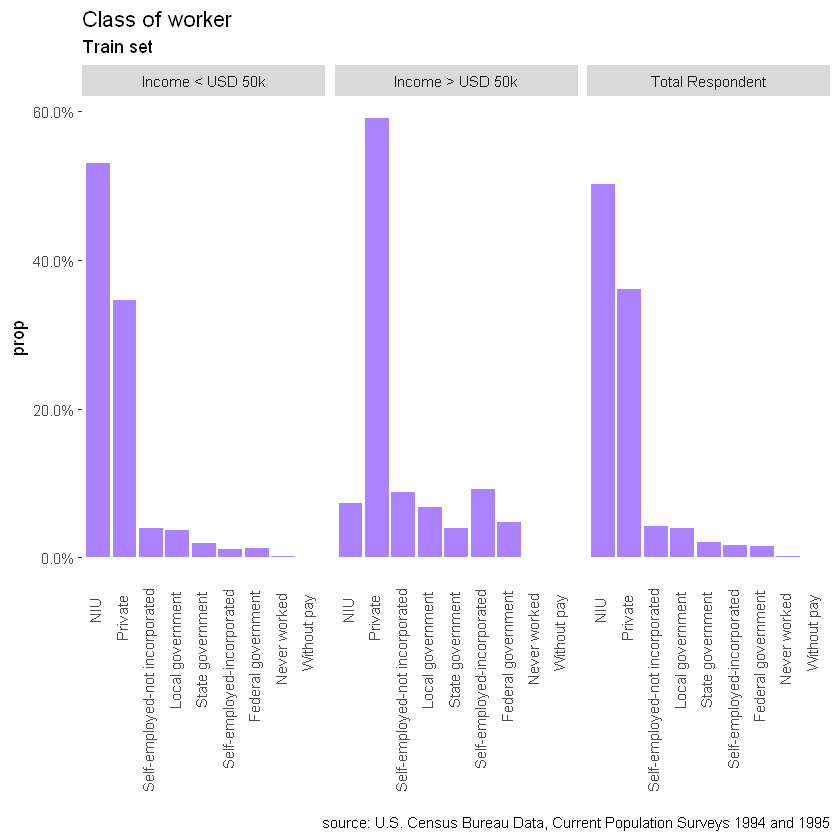

In [479]:
# Print analysis of an individual categorical variable to screen. 
suppressWarnings(print(plot_categorical_variable(variable = vars_cat[var_index], dataset = if(dataset_index == 1){train_data} else{test_data}, 
                               colour = sample(palette, 1), n = n, set_type = c("Train set", "Test set")[dataset_index])))

In [480]:
#### TO LOOP THROUGH ALL CATEGORICAL VARIABLES AND SAVE PLOTS TO DISK #####
# Save to disk distribution analysis of all categorical variables:
# ifelse(!dir.exists(file.path("outputs/EDA/Plots_Categorical_Vars")), dir.create("outputs/EDA/Plots_Categorical_Vars"), FALSE)
# for(v in vars_cat){
#   for(t in c("Train set", "Test set")){
#     png(paste0("outputs/EDA/Plots_Categorical_Vars/",v,"_",tolower(str_split(t, " ")[[1]][1]),"_set.png"))
#     dataset <- if(t == "Train set"){train_data} else {test_data}
#     p <- plot_categorical_variable(variable = v, dataset = dataset, colour = sample(palette, 1), n = n, set_type = t)
#     print(p)
#     dev.off()
#   }
# }

##### EXPLORE NUMERICAL VARIABLES
_UNIVARIATE DISTRIBUTIONS AND CONDITIONAL DISTRIBUTIONS VS. INCOME_

In [481]:
##### FUNCTION FOR PLOTTING NUMERIC VARIABLES #####
plot_numerical_variable <- function(variable, dataset, colour, set_type){
  
  var_of_interest <- dataset[,variable]
  
  # Create variable-specific dataframe:
  var_interest_df <- data.frame(var_interest = as.numeric(var_of_interest, na.rm=TRUE), income = dataset$income)
  
  var_mean_summary <- ddply(var_interest_df, "income", summarise, var_mean=mean(var_interest))
  var_median_summary <- ddply(var_interest_df, "income", summarise, var_median=median(var_interest))
  
  p_1 <- ggplot(var_interest_df, aes(x=var_of_interest, fill=income)) +
    geom_density(alpha = 0.3, show.legend = FALSE) + 
    scale_fill_manual(values=c("plum1", "turquoise1")) +
    xlab(proper_case(variable)) +
    labs(title = proper_case(variable), 
         subtitle = set_type, 
         caption ="") + #"U.S. Census Bureau Data, Current Population Surveys 1994 and 1995") +
    geom_vline(data=var_mean_summary, aes(xintercept=var_mean, color=income), show.legend = FALSE) +
    geom_text(data=var_mean_summary,aes(x=var_mean, label=paste0("Mean: ",round(var_mean, 2)), y=0.00, colour=income), size = 3, angle=90, hjust = -0.01, vjust = 1.1, show.legend = FALSE)
  
  p_2 <- ggplot(var_interest_df, aes(x=income, y=var_of_interest, fill=income)) + 
    geom_boxplot(alpha = 0.3) +
    scale_fill_manual(values=c("plum1", "turquoise1")) +
    ylab(proper_case(variable)) +
    labs(title = "", #proper_case(variable), 
         subtitle = "", #set_type, 
         caption = "source: U.S. Census Bureau Data, Current Population Surveys 1994 and 1995") +
    geom_text(data=var_median_summary, aes(x=income, y=var_median, label=paste0("Median: ",var_median), colour=income), size = 3, vjust = -0.5, show.legend = FALSE)
  
  p <- grid.arrange(p_1, p_2, ncol=2)
  
  return(p)
}

In [482]:
# Define parameters:
var_index <- 1 # options: [1...7]
dataset_index <- 1 # options: [1, 2] where 1 = train_data, and 2 = test_data

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


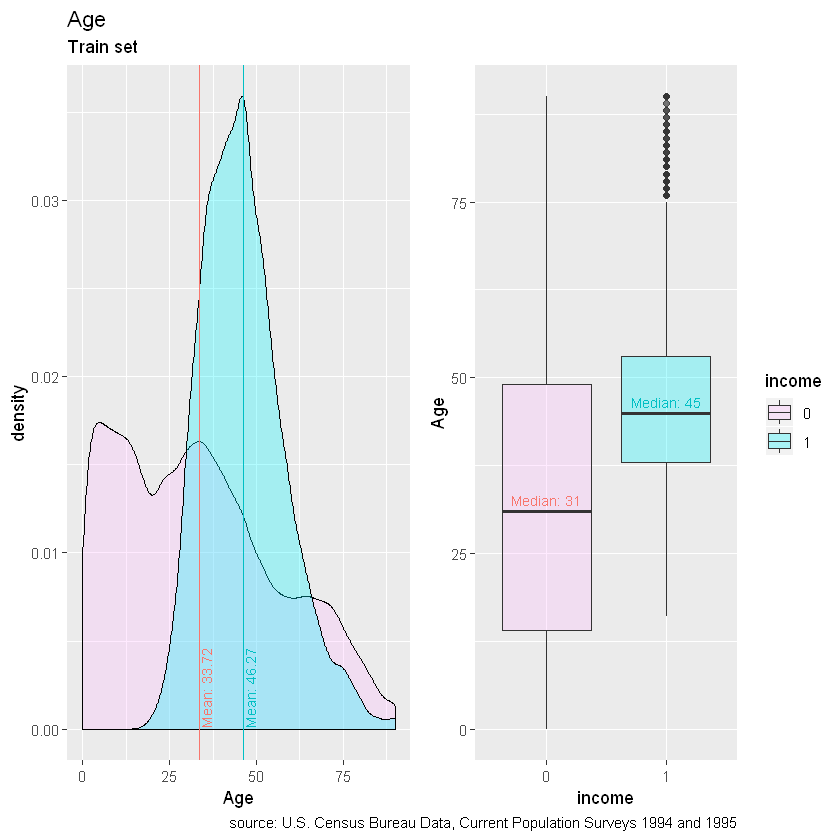

In [483]:
# Print analysis of an individual numerical variable to screen. 
print(plot_numerical_variable(variable = vars_num[var_index], dataset = if(dataset_index == 1){train_data} else{test_data}, 
                                                 colour = sample(palette, 1), set_type = c("Train set", "Test set")[dataset_index]))

## <font color=green>SUMMARY</font>
* The numerical variable num_persons_worked_for_employer (in parameters assign: var_index <- 6) seems **capped at 6**. We can infer this by observing that for individuals with incomes > USD 50k, the third quartile equals the maximun value of values for that particular variable.
* For most other numerical variables, except age, the median is zero for both individuals with < USD50k and > USD50k. Although there were no observed NAs in the summary statistics of numerical variables, this phenomenon could mean that information for this variable is actually missing, but was coded as "0" (zero).

In [484]:
##### GOOD HOUSEKEEPING #####
rm(list=setdiff(ls(), c("train_data", "test_data", "cat_vars_train", "cat_vars_test", 
                        "plot_numerical_variable", "plot_categorical_variable", "palette",
                        "proper_case", "outcome_labeller", "outcome_names")))
ls()

[1] "cat_vars_test"             "cat_vars_train"           
 [3] "outcome_labeller"          "outcome_names"            
 [5] "palette"                   "plot_categorical_variable"
 [7] "plot_numerical_variable"   "proper_case"              
 [9] "test_data"                 "train_data"

### 4. Manual imputation of NA/NIU

In [485]:
##### CREATE COPY OF TRAIN AND TEST SET FOR POSTERIOR ANALYSIS #####
copy_train_data <- train_data
copy_test_data <- test_data

In [486]:
# Convert categorical variables to character, in order to do manual recoding of factor levels:
train_data[,cat_vars_train] <- sapply(train_data[,cat_vars_train], as.character)
test_data[,cat_vars_test] <- sapply(test_data[,cat_vars_test], as.character)

**MANUAL IMPUTATION OF NA/NIU ON THE TRAINING SET**

**RECODING: class_of_worker**

In [487]:
# Initial NIU in variable: 
length(copy_train_data$class_of_worker[copy_train_data$class_of_worker == "NIU"]) # [1] 100245  
length(copy_train_data$class_of_worker[copy_train_data$class_of_worker == "NIU"]) / nrow(train_data) # Prop: 0.5024233

# Assign NIU of people below legal working age (Unrestricted by federal law) to factor level "Never worked": https://en.wikipedia.org/wiki/Legal_working_age
length(train_data$class_of_worker[train_data$class_of_worker == "NIU" & train_data$age < 16]) # [1] 49916
train_data$class_of_worker[train_data$class_of_worker == "NIU" & train_data$age < 16] <- "Never worked"

# Assign NIU of people above retirement age to NEW factor level "Pass retirement":
length(train_data$class_of_worker[train_data$class_of_worker == "NIU" & train_data$age > 64]) # [1] 21191
train_data$class_of_worker[train_data$class_of_worker == "NIU" & train_data$age > 64] <- "Pass retirement"

# Assign NIU of people of working age which are not in the labour force to NEW factor level "Not in labor force":
length(train_data$class_of_worker[train_data$class_of_worker == "NIU" & train_data$full_or_part_time_employment_stat == "Not in labor force"]) # [1] 14226
train_data$class_of_worker[train_data$class_of_worker == "NIU" & train_data$full_or_part_time_employment_stat == "Not in labor force"] <- "Not in labor force"

# Assign NIU of people of working age which did not work that year to NEW factor level "Not in labor force":
length(train_data$class_of_worker[train_data$class_of_worker == "NIU" & train_data$weeks_worked_in_year == 0]) # [1] 11051
train_data$class_of_worker[train_data$class_of_worker == "NIU" & train_data$weeks_worked_in_year == 0] <- "Not in labor force"

# Remaining NIU in variable: 
length(train_data$class_of_worker[train_data$class_of_worker == "NIU"]) # [1] 3861  
length(train_data$class_of_worker[train_data$class_of_worker == "NIU"]) / nrow(train_data) # Prop: 0.01935115

[1] 100245

[1] 0.5024233

[1] 49916

[1] 21191

[1] 14226

[1] 11051

[1] 3861

[1] 0.01935115

**RECODING: detailed_industry_recode, detailed_occupation_recode, major_industry_code, major_occupation_code**

In [488]:
# Initial NIU in variables:
length(copy_train_data$detailed_industry_recode[copy_train_data$detailed_industry_recode == 0]) # [1] 100684
length(copy_train_data$detailed_occupation_recode[copy_train_data$detailed_occupation_recode == 0]) # [1] 100684
length(copy_train_data$major_industry_code[copy_train_data$major_industry_code == "NIU"]) # [1] 100684
length(copy_train_data$major_occupation_code[copy_train_data$major_occupation_code == "NIU"]) # [1] 100684
length(copy_train_data$major_occupation_code[copy_train_data$major_occupation_code == "NIU"])/nrow(train_data) # Prop: 0.5046235

# Assign NIU of people below legal working age to factor level "Never worked":
length(train_data$detailed_industry_recode[train_data$detailed_industry_recode == 0 & train_data$age < 16]) # [1] 49960
train_data$detailed_industry_recode[train_data$detailed_industry_recode == 0 & train_data$age < 16] <- "Never worked"

length(train_data$detailed_occupation_recode[train_data$detailed_occupation_recode == 0 & train_data$age < 16]) # [1] 49960
train_data$detailed_occupation_recode[train_data$detailed_occupation_recode == 0 & train_data$age < 16] <-  "Never worked"

length(train_data$major_industry_code[train_data$major_industry_code == "NIU" & train_data$age < 16]) # [1] 49960
train_data$major_industry_code[train_data$major_industry_code == "NIU" & train_data$age < 16] <-  "Never worked"

length(train_data$major_occupation_code[train_data$major_occupation_code == "NIU" & train_data$age < 16]) # [1] 49960
train_data$major_occupation_code[train_data$major_occupation_code == "NIU" & train_data$age < 16] <-  "Never worked"

# Assign NIU of people above retirement age to NEW factor level "Pass retirement":
length(train_data$detailed_industry_recode[train_data$detailed_industry_recode == 0 & train_data$age > 64]) # [1] 21191
train_data$detailed_industry_recode[train_data$detailed_industry_recode == 0 & train_data$age > 64] <- "Pass retirement"

length(train_data$detailed_occupation_recode[train_data$detailed_occupation_recode == 0 & train_data$age > 64]) # [1] 21191
train_data$detailed_occupation_recode[train_data$detailed_occupation_recode == 0 & train_data$age > 64] <-  "Pass retirement"

length(train_data$major_industry_code[train_data$major_industry_code == "NIU" & train_data$age > 64]) # [1] 21191
train_data$major_industry_code[train_data$major_industry_code == "NIU" & train_data$age > 64] <-  "Pass retirement"

length(train_data$major_occupation_code[train_data$major_occupation_code == "NIU" & train_data$age > 64]) # [1] 21191
train_data$major_occupation_code[train_data$major_occupation_code == "NIU" & train_data$age > 64] <-  "Pass retirement"

# Assign NIU of people of working age which are not in the labour force to NEW factor level "Not in labor force":
length(train_data$detailed_industry_recode[train_data$detailed_industry_recode == 0 & train_data$full_or_part_time_employment_stat == "Not in labor force"]) # [1] 14226
train_data$detailed_industry_recode[train_data$detailed_industry_recode == 0 & train_data$full_or_part_time_employment_stat == "Not in labor force"] <- "Not in labor force"

length(train_data$detailed_occupation_recode[train_data$detailed_occupation_recode == 0 & train_data$full_or_part_time_employment_stat == "Not in labor force"]) # [1] 14226
train_data$detailed_occupation_recode[train_data$detailed_occupation_recode == 0 & train_data$full_or_part_time_employment_stat == "Not in labor force"] <- "Not in labor force"

length(train_data$major_industry_code[train_data$major_industry_code == "NIU" & train_data$full_or_part_time_employment_stat == "Not in labor force"]) # [1] 14226
train_data$major_industry_code[train_data$major_industry_code == "NIU" & train_data$full_or_part_time_employment_stat == "Not in labor force"] <- "Not in labor force"

length(train_data$major_occupation_code[train_data$major_occupation_code == "NIU" & train_data$full_or_part_time_employment_stat == "Not in labor force"]) # [1] 14226
train_data$major_occupation_code[train_data$major_occupation_code == "NIU" & train_data$full_or_part_time_employment_stat == "Not in labor force"] <- "Not in labor force"

# Assign NIU of people of working age which did not work that year to NEW factor level "Not in labor force":
length(train_data$detailed_industry_recode[train_data$detailed_industry_recode == 0 & train_data$weeks_worked_in_year == 0]) # [1] 11408
train_data$detailed_industry_recode[train_data$detailed_industry_recode == 0 & train_data$weeks_worked_in_year == 0] <- "Not in labor force"

length(train_data$detailed_occupation_recode[train_data$detailed_occupation_recode == 0 & train_data$weeks_worked_in_year == 0]) # [1] 11408
train_data$detailed_occupation_recode[train_data$detailed_occupation_recode == 0 & train_data$weeks_worked_in_year == 0] <- "Not in labor force"

length(train_data$major_industry_code[train_data$major_industry_code == "NIU" & train_data$weeks_worked_in_year == 0]) # [1] 11408
train_data$major_industry_code[train_data$major_industry_code == "NIU" & train_data$weeks_worked_in_year == 0] <- "Not in labor force"

length(train_data$major_occupation_code[train_data$major_occupation_code == "NIU" & train_data$weeks_worked_in_year == 0]) # [1] 11408
train_data$major_occupation_code[train_data$major_occupation_code == "NIU" & train_data$weeks_worked_in_year == 0] <- "Not in labor force"

# Remaining NIU in variables: 
length(train_data$major_occupation_code[train_data$major_occupation_code == "NIU"]) # [1] 3899
length(train_data$major_occupation_code[train_data$major_occupation_code == "NIU"])/nrow(train_data) # Prop: 0.01954161

[1] 100684

[1] 100684

[1] 100684

[1] 100684

[1] 0.5046235

[1] 49960

[1] 49960

[1] 49960

[1] 49960

[1] 21191

[1] 21191

[1] 21191

[1] 21191

[1] 14226

[1] 14226

[1] 14226

[1] 14226

[1] 11408

[1] 11408

[1] 11408

[1] 11408

[1] 3899

[1] 0.01954161

**RECODING: country_of_birth_self, country_of_birth_father, country_of_birth_mother**

In [489]:
# Assign NIU of father's country of origin to mother's, and viceversa.
# Assumption: 93% of parents are born in the same country:
sum(train_data$country_of_birth_father == train_data$country_of_birth_mother)/nrow(train_data) # [1] 0.9296522
# For country of father:
length(train_data$country_of_birth_father[train_data$country_of_birth_father == "NA" & train_data$country_of_birth_mother != "NA"]) # [1] 1834
train_data$country_of_birth_father[train_data$country_of_birth_father == "NA" & train_data$country_of_birth_mother != "NA"] <- 
  train_data$country_of_birth_mother[train_data$country_of_birth_father == "NA" & train_data$country_of_birth_mother != "NA"]
# For country of mother:
length(train_data$country_of_birth_mother[train_data$country_of_birth_mother == "NA" & train_data$country_of_birth_father != "NA"]) # [1] 1240
train_data$country_of_birth_mother[train_data$country_of_birth_mother == "NA" & train_data$country_of_birth_father != "NA"] <- 
  train_data$country_of_birth_father[train_data$country_of_birth_mother == "NA" & train_data$country_of_birth_father != "NA"]

[1] 0.9296522

[1] 1834

[1] 1240

**MANUAL IMPUTATION OF NA/NIU ON THE TEST SET**

**RECODING: class_of_worker**

In [490]:
# Initial NIU in variable: 
length(copy_test_data$class_of_worker[copy_test_data$class_of_worker == "NIU"]) # [1] 50079
length(copy_test_data$class_of_worker[copy_test_data$class_of_worker == "NIU"]) / nrow(test_data) # Prop: 0.5019847

# Assign NIU of people below legal working age (Unrestricted by federal law) to factor level "Never worked": https://en.wikipedia.org/wiki/Legal_working_age
length(test_data$class_of_worker[test_data$class_of_worker == "NIU" & test_data$age < 16]) # [1] 24698
test_data$class_of_worker[test_data$class_of_worker == "NIU" & test_data$age < 16] <- "Never worked"

# Assign NIU of people above retirement age to NEW factor level "Pass retirement":
length(test_data$class_of_worker[test_data$class_of_worker == "NIU" & test_data$age > 64]) # [1] 10829
test_data$class_of_worker[test_data$class_of_worker == "NIU" & test_data$age > 64] <- "Pass retirement"

# Assign NIU of people of working age which are not in the labour force to NEW factor level "Not in labor force":
length(test_data$class_of_worker[test_data$class_of_worker == "NIU" & test_data$full_or_part_time_employment_stat == "Not in labor force"]) # [1] 7046
test_data$class_of_worker[test_data$class_of_worker == "NIU" & test_data$full_or_part_time_employment_stat == "Not in labor force"] <- "Not in labor force"

# Assign NIU of people of working age which did not work that year to NEW factor level "Not in labor force":
length(test_data$class_of_worker[test_data$class_of_worker == "NIU" & test_data$weeks_worked_in_year == 0]) # [1] 5534
test_data$class_of_worker[test_data$class_of_worker == "NIU" & test_data$weeks_worked_in_year == 0] <- "Not in labor force"

# Remaining NIU in variable: 
length(test_data$class_of_worker[test_data$class_of_worker == "NIU"]) # [1] 1972
length(test_data$class_of_worker[test_data$class_of_worker == "NIU"]) / nrow(test_data) # Prop: 0.01976705

[1] 50079

[1] 0.5019847

[1] 24698

[1] 10829

[1] 7046

[1] 5534

[1] 1972

[1] 0.01976705

**RECODING: detailed_industry_recode, detailed_occupation_recode, major_industry_code, major_occupation_code**

In [491]:
# Initial NIU in variables:
length(copy_test_data$detailed_industry_recode[copy_test_data$detailed_industry_recode == 0]) # [1] 50283
length(copy_test_data$detailed_occupation_recode[copy_test_data$detailed_occupation_recode == 0]) # [1] 50283
length(copy_test_data$major_industry_code[copy_test_data$major_industry_code == "NIU"]) # [1] 50283
length(copy_test_data$major_occupation_code[copy_test_data$major_occupation_code == "NIU"]) # [1] 50283
length(copy_test_data$major_occupation_code[copy_test_data$major_occupation_code == "NIU"])/nrow(test_data) # Prop: 0.5040296

# Assign NIU of people below legal working age to factor level "Never worked":
length(test_data$detailed_industry_recode[test_data$detailed_industry_recode == 0 & test_data$age < 16]) # [1] 24725
test_data$detailed_industry_recode[test_data$detailed_industry_recode == 0 & test_data$age < 16] <- "Never worked"

length(test_data$detailed_occupation_recode[test_data$detailed_occupation_recode == 0 & test_data$age < 16]) # [1] 24725
test_data$detailed_occupation_recode[test_data$detailed_occupation_recode == 0 & test_data$age < 16] <-  "Never worked"

length(test_data$major_industry_code[test_data$major_industry_code == "NIU" & test_data$age < 16]) # [1] 24725
test_data$major_industry_code[test_data$major_industry_code == "NIU" & test_data$age < 16] <-  "Never worked"

length(test_data$major_occupation_code[test_data$major_occupation_code == "NIU" & test_data$age < 16]) # [1] 24725
test_data$major_occupation_code[test_data$major_occupation_code == "NIU" & test_data$age < 16] <-  "Never worked"

# Assign NIU of people above retirement age to NEW factor level "Pass retirement":
length(test_data$detailed_industry_recode[test_data$detailed_industry_recode == 0 & test_data$age > 64]) # [1] 10829
test_data$detailed_industry_recode[test_data$detailed_industry_recode == 0 & test_data$age > 64] <- "Pass retirement"

length(test_data$detailed_occupation_recode[test_data$detailed_occupation_recode == 0 & test_data$age > 64]) # [1] 10829
test_data$detailed_occupation_recode[test_data$detailed_occupation_recode == 0 & test_data$age > 64] <-  "Pass retirement"

length(test_data$major_industry_code[test_data$major_industry_code == "NIU" & test_data$age > 64]) # [1] 10829
test_data$major_industry_code[test_data$major_industry_code == "NIU" & test_data$age > 64] <-  "Pass retirement"

length(test_data$major_occupation_code[test_data$major_occupation_code == "NIU" & test_data$age > 64]) # [1] 10829
test_data$major_occupation_code[test_data$major_occupation_code == "NIU" & test_data$age > 64] <-  "Pass retirement"

# Assign NIU of people of working age which are not in the labour force to NEW factor level "Not in labor force":
length(test_data$detailed_industry_recode[test_data$detailed_industry_recode == 0 & test_data$full_or_part_time_employment_stat == "Not in labor force"]) # [1] 7046
test_data$detailed_industry_recode[test_data$detailed_industry_recode == 0 & test_data$full_or_part_time_employment_stat == "Not in labor force"] <- "Not in labor force"

length(test_data$detailed_occupation_recode[test_data$detailed_occupation_recode == 0 & test_data$full_or_part_time_employment_stat == "Not in labor force"]) # [1] 7046
test_data$detailed_occupation_recode[test_data$detailed_occupation_recode == 0 & test_data$full_or_part_time_employment_stat == "Not in labor force"] <- "Not in labor force"

length(test_data$major_industry_code[test_data$major_industry_code == "NIU" & test_data$full_or_part_time_employment_stat == "Not in labor force"]) # [1] 7046
test_data$major_industry_code[test_data$major_industry_code == "NIU" & test_data$full_or_part_time_employment_stat == "Not in labor force"] <- "Not in labor force"

length(test_data$major_occupation_code[test_data$major_occupation_code == "NIU" & test_data$full_or_part_time_employment_stat == "Not in labor force"]) # [1] 7046
test_data$major_occupation_code[test_data$major_occupation_code == "NIU" & test_data$full_or_part_time_employment_stat == "Not in labor force"] <- "Not in labor force"

# Assign NIU of people of working age which did not work that year to NEW factor level "Not in labor force":
length(test_data$detailed_industry_recode[test_data$detailed_industry_recode == 0 & test_data$weeks_worked_in_year == 0]) # [1] 5695
test_data$detailed_industry_recode[test_data$detailed_industry_recode == 0 & test_data$weeks_worked_in_year == 0] <- "Not in labor force"

length(test_data$detailed_occupation_recode[test_data$detailed_occupation_recode == 0 & test_data$weeks_worked_in_year == 0]) # [1] 5695
test_data$detailed_occupation_recode[test_data$detailed_occupation_recode == 0 & test_data$weeks_worked_in_year == 0] <- "Not in labor force"

length(test_data$major_industry_code[test_data$major_industry_code == "NIU" & test_data$weeks_worked_in_year == 0]) # [1] 5695
test_data$major_industry_code[test_data$major_industry_code == "NIU" & test_data$weeks_worked_in_year == 0] <- "Not in labor force"

length(test_data$major_occupation_code[test_data$major_occupation_code == "NIU" & test_data$weeks_worked_in_year == 0]) # [1] 5695
test_data$major_occupation_code[test_data$major_occupation_code == "NIU" & test_data$weeks_worked_in_year == 0] <- "Not in labor force"

# Remaining NIU in variables: 
length(test_data$major_occupation_code[test_data$major_occupation_code == "NIU"]) # [1] 1988
length(test_data$major_occupation_code[test_data$major_occupation_code == "NIU"])/nrow(test_data) # Prop: 0.01992743

[1] 50283

[1] 50283

[1] 50283

[1] 50283

[1] 0.5040296

[1] 24725

[1] 24725

[1] 24725

[1] 24725

[1] 10829

[1] 10829

[1] 10829

[1] 10829

[1] 7046

[1] 7046

[1] 7046

[1] 7046

[1] 5695

[1] 5695

[1] 5695

[1] 5695

[1] 1988

[1] 0.01992743

**RECODING: country_of_birth_father, country_of_birth_mother**

In [492]:
# Assign NIU of father's country of origin to mother's, and viceversa.
# Assumption: 93% of parents are born in the same country:
sum(test_data$country_of_birth_father == test_data$country_of_birth_mother)/nrow(test_data) # [1] 0.9289208
# For country of father:
length(test_data$country_of_birth_father[test_data$country_of_birth_father == "NA" & test_data$country_of_birth_mother != "NA"]) # [1] 981
test_data$country_of_birth_father[test_data$country_of_birth_father == "NA" & test_data$country_of_birth_mother != "NA"] <- 
  test_data$country_of_birth_mother[test_data$country_of_birth_father == "NA" & test_data$country_of_birth_mother != "NA"]
# For country of mother:
length(test_data$country_of_birth_mother[test_data$country_of_birth_mother == "NA" & test_data$country_of_birth_father != "NA"]) # [1] 624
test_data$country_of_birth_mother[test_data$country_of_birth_mother == "NA" & test_data$country_of_birth_father != "NA"] <- 
  test_data$country_of_birth_father[test_data$country_of_birth_mother == "NA" & test_data$country_of_birth_father != "NA"]

[1] 0.9289208

[1] 981

[1] 624

### SANITY CHECK OF FACTOR LEVELS

In [493]:
# Convert categorical variables back to factors:
train_data  <- train_data %>%
  mutate_at(.vars = (names(train_data)[cat_vars_train]), funs(as.factor(.)))

test_data  <- test_data %>%
  mutate_at(.vars = (names(test_data)[cat_vars_test]), funs(as.factor(.)))

In [494]:
compare_factors <- compare(train_data, test_data)
print(compare_factors$vars.summary)
# RESULTS: Only one factor level difference between train set and test set in variable "detailed_household_and_family_stat". 
# This variable misses one factor level in the test set which does appear in the training set. This will not affect the algorithms downstream:
#
#                                       var.x pos.x class.x                                     var.y pos.y class.y            values        attrs
# 10        detailed_household_and_family_stat    23  factor        detailed_household_and_family_stat    23  factor 92884 differences 1 attributes

                                       var.x pos.x class.x
2                                        age     1 integer
6                            class_of_worker     2  factor
12                  detailed_industry_recode     3  factor
13                detailed_occupation_recode     4  factor
15                                 education     5  factor
40                             wage_per_hour     6 integer
16                enroll_in_edu_inst_last_wk     7  factor
25                              marital_stat     8  factor
23                       major_industry_code     9  factor
24                     major_occupation_code    10  factor
33                                      race    11  factor
20                           hispanic_origin    12  factor
36                                       sex    13  factor
26                   member_of_a_labor_union    14  factor
34                   reason_for_unemployment    15  factor
19         full_or_part_time_employment_stat    16  fact

In [495]:
##### GOOD HOUSEKEEPING #####
rm(list=setdiff(ls(), c("train_data", "test_data", "cat_vars_train", "cat_vars_test",
                       "plot_numerical_variable", "plot_categorical_variable", "palette",
                        "proper_case", "outcome_labeller", "outcome_names")))
ls()

[1] "cat_vars_test"             "cat_vars_train"           
 [3] "outcome_labeller"          "outcome_names"            
 [5] "palette"                   "plot_categorical_variable"
 [7] "plot_numerical_variable"   "proper_case"              
 [9] "test_data"                 "train_data"

### 5. Recoding Categorical Variables

**RECODING OF CATEGORICAL VARIABLES IN THE TRAINING SET**

In [496]:
# Convert categorical variables to character:
train_data[,cat_vars_train] <- sapply(train_data[,cat_vars_train], as.character)
test_data[,cat_vars_test] <- sapply(test_data[,cat_vars_test], as.character)

**RECODING: education**

In [497]:
# Reduce number of factors:
prop.table(table(train_data$education, train_data$income), 1)
edu_curr_levels <- c("High school graduate", "Some college but no degree", "10th grade", "Children", "Bachelors degree(BA AB BS)", 
                     "Masters degree(MA MS MEng MEd MSW MBA)", "Less than 1st grade", "Associates degree-academic program", "7th and 8th grade",
                     "12th grade no diploma", "Associates degree-occup /vocational", "Prof school degree (MD DDS DVM LLB JD)", "5th or 6th grade",
                     "11th grade", "Doctorate degree(PhD EdD)", "9th grade", "1st 2nd 3rd or 4th grade")
length(unique(edu_curr_levels)) # [1] 17

edu_new_levels <- c("School finished", "Undergraduate unfinished", "School unfinished", "Children", "Undergraduate finished", "Graduate", "No school",
                    "Undergraduate unfinished", "School unfinished", "School unfinished", "Undergraduate unfinished", "Post Graduate", "School unfinished",
                    "School unfinished", "Post Graduate", "School unfinished", "School unfinished")
length(unique(edu_new_levels)) # [1] 8

# Create a named vector for applying the replacements to the datasets:
names(edu_new_levels) <- edu_curr_levels

# Replace current factor levels with new ones:
train_data$education[] <- edu_new_levels[train_data$education]
test_data$education[] <- edu_new_levels[test_data$education]

                                        
                                                   0           1
  10th grade                             0.991795686 0.008204314
  11th grade                             0.989819663 0.010180337
  12th grade no diploma                  0.984007526 0.015992474
  1st 2nd 3rd or 4th grade               0.992773763 0.007226237
  5th or 6th grade                       0.993286543 0.006713457
  7th and 8th grade                      0.991007868 0.008992132
  9th grade                              0.993900482 0.006099518
  Associates degree-academic program     0.905569562 0.094430438
  Associates degree-occup /vocational    0.922919000 0.077081000
  Bachelors degree(BA AB BS)             0.802919708 0.197080292
  Children                               1.000000000 0.000000000
  Doctorate degree(PhD EdD)              0.479809976 0.520190024
  High school graduate                   0.961183300 0.038816700
  Less than 1st grade                    0.998778

[1] 17

[1] 8

**RECODING: hispanic_origin**

In [498]:
# Reduce number of factors: Join "Mexican (Mexicano)", "Mexican-American", and "Chicano", as they represent the same mexican origin.
mex_curr_levels <- c("Mexican (Mexicano)", "Mexican-American", "Chicano")
mex_new_level <- "Mexican"

sum(train_data$hispanic_origin %in% mex_curr_levels) # [1] 15617
sum(test_data$hispanic_origin %in% mex_curr_levels) # [1] 7866

train_data$hispanic_origin[train_data$hispanic_origin %in% mex_curr_levels] <- mex_new_level
test_data$hispanic_origin[test_data$hispanic_origin %in% mex_curr_levels] <- mex_new_level

[1] 15617

[1] 7866

**RECODING: capital_gains, capital_losses, dividends_from_stocks**

In [499]:
# capital_gains:
cap_gains_bins <- cut(train_data$capital_gains, breaks = seq(0, max(train_data$capital_gains) + 1, round(max(train_data$capital_gains)/10)), right = FALSE, dig.lab = 10)
table(cap_gains_bins, train_data$income)
prop.table(table(cap_gains_bins, train_data$income),1) # Probabilities of income > 50,000 reverse when capital_gains > 10,000:
threshold_cap_gains <- 10000
train_data$capital_gains <- ifelse(train_data$capital_gains < threshold_cap_gains, "0", "1")
test_data$capital_gains <- ifelse(test_data$capital_gains < threshold_cap_gains, "0", "1")

# capital_losses:
cap_loss_bins <- cut(train_data$capital_losses, breaks = c(0,1900,5000), right = FALSE, dig.lab = 10)
table(cap_loss_bins, train_data$income)
prop.table(table(cap_loss_bins, train_data$income),1) # Probabilities of income > 50,000 around 50% when capital_losses > 1,900:
threshold_cap_loss <- 1900
train_data$capital_losses <- ifelse(train_data$capital_losses < threshold_cap_loss, "0", "1")
test_data$capital_losses <- ifelse(test_data$capital_losses < threshold_cap_loss, "0", "1")

# dividends_from_stocks:
divs_stocks_bins <- cut(train_data$dividends_from_stocks, breaks = c(0, 15000, 100000), right = FALSE, dig.lab = 10) #breaks = seq(0, max(train_data$dividends_from_stocks) + 1, round(max(train_data$dividends_from_stocks)/100))
table(divs_stocks_bins, train_data$income)
prop.table(table(divs_stocks_bins, train_data$income),1) # Probabilities of income > 50,000 around 50% when dividends_from_stocks > 1,900:
threshold_divs_stocks <- 15000
train_data$dividends_from_stocks <- ifelse(train_data$dividends_from_stocks < threshold_divs_stocks, "0", "1")
test_data$dividends_from_stocks <- ifelse(test_data$dividends_from_stocks < threshold_divs_stocks, "0", "1")

                
cap_gains_bins        0      1
  [0,10000)      186868  10809
  [10000,20000)     200   1015
  [20000,30000)      14    214
  [30000,40000)      11      0
  [40000,50000)       2      0
  [50000,60000)       0      0
  [60000,70000)       0      0
  [70000,80000)       0      0
  [80000,90000)       0      0
  [90000,100000)     46    344

                
cap_gains_bins            0          1
  [0,10000)      0.94531989 0.05468011
  [10000,20000)  0.16460905 0.83539095
  [20000,30000)  0.06140351 0.93859649
  [30000,40000)  1.00000000 0.00000000
  [40000,50000)  1.00000000 0.00000000
  [50000,60000)                       
  [60000,70000)                       
  [70000,80000)                       
  [80000,90000)                       
  [90000,100000) 0.11794872 0.88205128

             
cap_loss_bins      0      1
  [0,1900)    186106  11477
  [1900,5000)   1035    905

             
cap_loss_bins          0          1
  [0,1900)    0.94191302 0.05808698
  [1900,5000) 0.53350515 0.46649485

                
divs_stocks_bins      0      1
  [0,15000)      186991  12071
  [15000,100000)    150    311

                
divs_stocks_bins         0         1
  [0,15000)      0.9393606 0.0606394
  [15000,100000) 0.3253796 0.6746204

### SANITY CHECK OF FACTOR LEVELS

In [500]:
# Convert categorical variables back to factors:
train_data  <- train_data %>%  
  mutate_at(.vars = (names(train_data)[unname(sapply(train_data, class)) == "character"]), funs(as.factor(.)))

test_data  <- test_data %>%
  mutate_at(.vars = (names(test_data)[unname(sapply(test_data, class)) == "character"]), funs(as.factor(.)))

In [501]:
compare_factors <- compare(train_data, test_data)
print(compare_factors$vars.summary)
# RESULTS: Facor levels remain the same between train and test set (only one factor level missing for variable detailed_household_and_family_stat in test set) after recoding.
# 
#                                       var.x pos.x class.x                                     var.y pos.y class.y            values        attrs
# 10        detailed_household_and_family_stat    23  factor        detailed_household_and_family_stat    23  factor 92884 differences 1 attributes

                                       var.x pos.x class.x
2                                        age     1 integer
6                            class_of_worker     2  factor
12                  detailed_industry_recode     3  factor
13                detailed_occupation_recode     4  factor
15                                 education     5  factor
40                             wage_per_hour     6 integer
16                enroll_in_edu_inst_last_wk     7  factor
25                              marital_stat     8  factor
23                       major_industry_code     9  factor
24                     major_occupation_code    10  factor
33                                      race    11  factor
20                           hispanic_origin    12  factor
36                                       sex    13  factor
26                   member_of_a_labor_union    14  factor
34                   reason_for_unemployment    15  factor
19         full_or_part_time_employment_stat    16  fact

In [502]:
##### GOOD HOUSEKEEPING #####
rm(list=setdiff(ls(), c("train_data", "test_data", "cat_vars_train", "cat_vars_test",
                       "plot_numerical_variable", "plot_categorical_variable", "palette",
                        "proper_case", "outcome_labeller", "outcome_names")))
ls()

[1] "cat_vars_test"             "cat_vars_train"           
 [3] "outcome_labeller"          "outcome_names"            
 [5] "palette"                   "plot_categorical_variable"
 [7] "plot_numerical_variable"   "proper_case"              
 [9] "test_data"                 "train_data"

### 6. Treatment of remaining missing values

In [503]:
# Convert remaining "NA" and "NIU" to NA:
train_data[,cat_vars_train] <- sapply(train_data[,cat_vars_train], as.character)
train_data[train_data == "NA"] <- NA
train_data[train_data == "NIU"] <- NA
train_data  <- train_data %>%
  mutate_at(.vars = (names(train_data)[cat_vars_train]), funs(as.factor(.)))

test_data[,cat_vars_test] <- sapply(test_data[,cat_vars_test], as.character)
test_data[test_data == "NA"] <- NA
test_data[test_data == "NIU"] <- NA
test_data  <- test_data %>%
  mutate_at(.vars = (names(test_data)[cat_vars_test]), funs(as.factor(.)))

##### JOIN TRAIN AND TEST SET #####
full_data <- rbind(train_data, test_data)

# Subset data with variables containing NA:
full_data_with_na <- full_data[colnames(full_data)[colSums(is.na(full_data)) > 0]]
# Unburden memory usage:
rm(full_data)

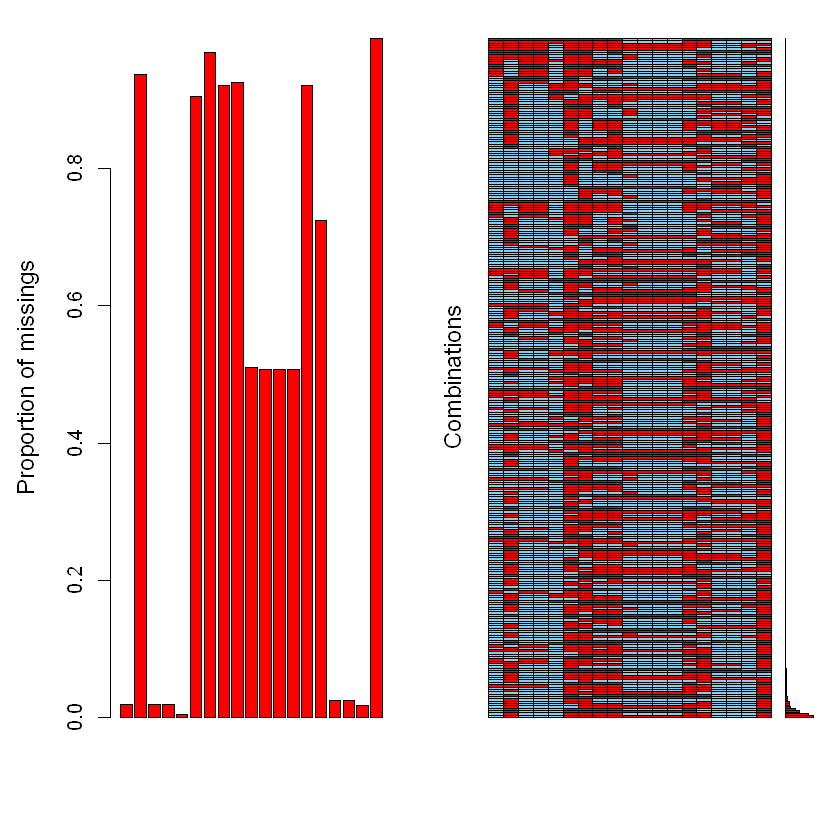


 Variables sorted by number of missings: 
   Variable       Count
 fill_inc_q 0.989939355
 reason_for 0.969260070
 enroll_in_ 0.936789348
 state_of_p 0.925058055
 region_of_ 0.921589789
 migration_ 0.921589789
 member_of_ 0.904629367
 family_mem 0.723811751
 migration_ 0.509584510
 migration_ 0.507479493
 migration_ 0.507479493
 live_in_th 0.507479493
 country_of 0.024481681
 country_of 0.024481681
 major_indu 0.019670214
 major_occu 0.019670214
 class_of_w 0.019489784
 country_of 0.017231067
 hispanic_o 0.004273519


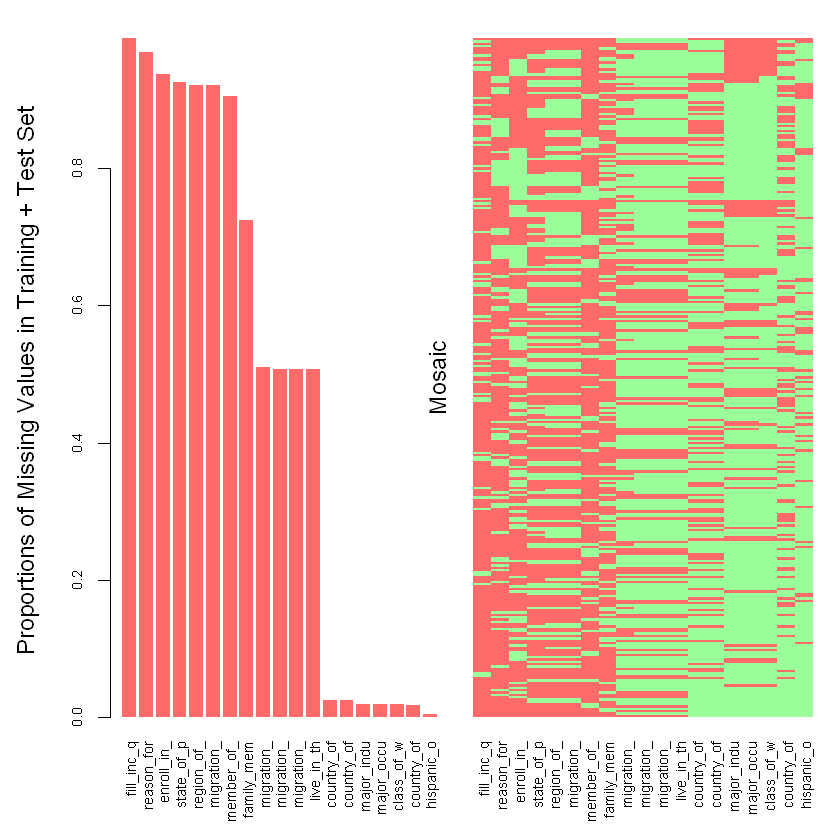

In [504]:
##### MAP MISSING VALUES IN FULL DATASET #####
aggr_plot <- aggr(full_data_with_na)
plot(aggr_plot, col=c('palegreen1','indianred1'), combined = FALSE, sortVars=TRUE, only.miss = FALSE, bars = FALSE, border = NA,
     labels=str_sub(names(full_data_with_na), start = 1, end = 10), cex.numbers= 0.5, cex.axis=0.7, gap=1, 
     ylab=c("Proportions of Missing Values in Training + Test Set ","Mosaic"))

In [505]:
# Unburden memory usage:
rm(full_data_with_na)

In [506]:
# Choose variables to remove from dataset based on threshold of proportion of missing values:
threshold <- 0.05
missing_vars <- aggr_plot$missings
vars_to_remove <- missing_vars %>%
  mutate(props = Count / (nrow(train_data) + nrow(test_data))) %>%
  filter(props > threshold) %>%
  select(Variable) %>%
  pull()

In [507]:
##### REMOVE SELECTED VARIABLES FROM DATASET #####
train_data <- train_data[,!names(train_data) %in% vars_to_remove]
test_data <- test_data[,!names(test_data) %in% vars_to_remove]

In [508]:
##### GOOD HOUSEKEEPING #####
rm(list=setdiff(ls(), c("train_data", "test_data", "plot_numerical_variable", "plot_categorical_variable", "palette",
                        "proper_case", "outcome_labeller", "outcome_names")))
ls()

[1] "outcome_labeller"          "outcome_names"            
[3] "palette"                   "plot_categorical_variable"
[5] "plot_numerical_variable"   "proper_case"              
[7] "test_data"                 "train_data"

# <font color=blue>4. Model Construction</font>
Modelling in this project consists of the following tasks:
1. Transform categorical variables to numeric with Weight Of Evidence.
2. Estimate variable importance.
3. Estimate correlation between variables.
4. Build base models: GBM, RPART, BAGGED CART.

### 1. WOE transformation of categorical variables

In [509]:
##### UPDATE VECTOR IDENTIFYING VARIABLE TYPES AND EXCLUDE OUTCOME VARIABLE #####
# Identify new set of categorical values, as some variables were removed:
cat_vars_train <- unname(sapply(train_data[1:ncol(train_data)-1], class)) == "factor"
cat_vars_test <- unname(sapply(test_data[1:ncol(test_data)-1], class)) == "factor"
all(cat_vars_train == cat_vars_test)

[1] TRUE

In [510]:
##### MANAGEMENT OF REMAINING NAs #####
# Assign factor level "Other" to remaining NA values (in variables which had < 5% of NA values):
train_data[,cat_vars_train] <- sapply(train_data[,cat_vars_train], as.character)
train_data[is.na(train_data)] <- "Other"
train_data  <- train_data %>%
  mutate_at(.vars = (names(train_data)[cat_vars_train]), funs(as.factor(.)))

test_data[,cat_vars_test] <- sapply(test_data[,cat_vars_test], as.character)
test_data[is.na(test_data)] <- "Other"
test_data  <- test_data %>%
  mutate_at(.vars = (names(test_data)[cat_vars_test]), funs(as.factor(.)))

In [511]:
# Calculate WOE for all categorical variables:
train_data[,cat_vars_train] <- sapply(train_data[,cat_vars_train], function(x) WOE(x, train_data$income, valueOfGood = 1))
test_data[,cat_vars_test] <- sapply(test_data[,cat_vars_test], function(x) WOE(x, test_data$income, valueOfGood = 1))

### 2. Estimate variable importance

In [512]:
# Change outcome variable factor levels for binary classification algorithm:
levels(train_data$income) <- c("less", "more")
levels(test_data$income) <- c("less", "more")

In [513]:
# Set control parameters for model training:
# Use smote for sampling to compensate for the significant class imbalance in the "income" outcome variable:
control <- trainControl(sampling = "smote", method="cv", number=10)

In [514]:
# Train gbm model for calculating variable importance:
#t1 <- Sys.time()
#model_gbm_var_imp <- train(income~., data=train_data, method="gbm", trControl=control)
#t2 <- Sys.time() 
#t2 - t1 # Time difference of 1.108251 hours

In [515]:
#ifelse(!dir.exists(file.path("outputs/feature_engineering")), dir.create("outputs/feature_engineering"), "Folder already exists.")
#saveRDS(model_gbm_var_imp, file = "outputs/feature_engineering/model_gbm_var_imp.RDS")
model_gbm_var_imp <- readRDS(file = "outputs/feature_engineering/model_gbm_var_imp.RDS")

In [516]:
# Estimate variable importance:
var_importance_woe <- varImp(model_gbm_var_imp, scale=FALSE)

In [517]:
# Summarize importance:
print(var_importance_woe)

gbm variable importance

  only 20 most important variables shown (out of 27)

                                         Overall
weeks_worked_in_year                    12206.39
education                                7106.40
age                                      5612.18
detailed_occupation_recode               5608.90
detailed_household_summary_in_household  2926.11
sex                                      1469.58
capital_gains                            1014.78
tax_filer_stat                            984.56
num_persons_worked_for_employer           632.09
class_of_worker                           499.55
dividends_from_stocks                     344.23
detailed_industry_recode                  311.61
capital_losses                            216.82
marital_stat                              183.18
own_business_or_self_employed             139.69
detailed_household_and_family_stat        113.74
country_of_birth_mother                   106.12
wage_per_hour                          

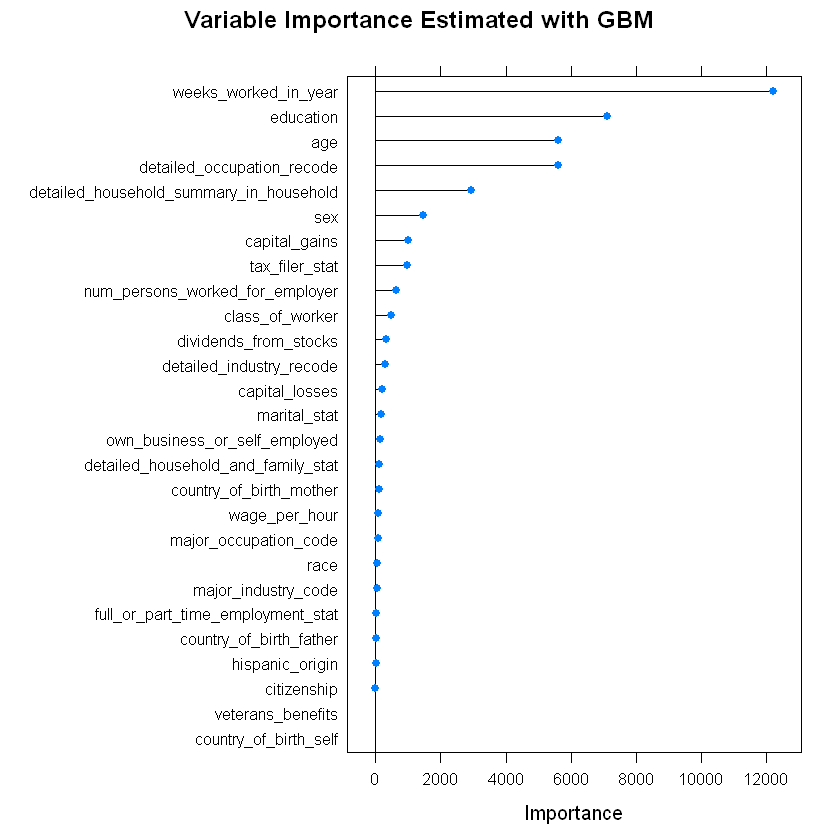

In [518]:
# Plot and save variable importance:
plot(var_importance_woe, main = "Variable Importance Estimated with GBM")

### 3. Estimate correlation between variables
Estimation of correlation between variables is carried out in order to reduce predictor multicolinearity and its confounding effect on the outcome variable. Highly correlated variables are analysed, and selection of variables to remove are human-curated in spite of algorithmic recommendations. The heuristic used is that if one of the variables flagged for removal due to multicolinearity is among the top-n variables in term of importance, the other (or chained) correlated variable is selected for removal instead.

In [519]:
# Calculate correlations between variables:
corr_matrix <- cor(train_data[,1:ncol(train_data) - 1])
highly_correlated <- findCorrelation(corr_matrix, cutoff=0.75, names = TRUE, verbose = TRUE)

Compare row 2  and column  26 with corr  0.925 
  Means:  0.39 vs 0.197 so flagging column 2 
Compare row 26  and column  19 with corr  0.831 
  Means:  0.368 vs 0.182 so flagging column 26 
Compare row 19  and column  18 with corr  0.973 
  Means:  0.333 vs 0.168 so flagging column 19 
Compare row 4  and column  8 with corr  0.849 
  Means:  0.272 vs 0.155 so flagging column 4 
Compare row 8  and column  3 with corr  0.992 
  Means:  0.242 vs 0.146 so flagging column 8 
Compare row 3  and column  9 with corr  0.856 
  Means:  0.207 vs 0.138 so flagging column 3 
Compare row 21  and column  22 with corr  0.87 
  Means:  0.166 vs 0.133 so flagging column 21 
All correlations <= 0.75 


In [520]:
print(highly_correlated)

[1] "class_of_worker"                        
[2] "veterans_benefits"                      
[3] "detailed_household_summary_in_household"
[4] "detailed_occupation_recode"             
[5] "major_industry_code"                    
[6] "detailed_industry_recode"               
[7] "country_of_birth_father"                


## <font color=green>SUMMARY</font>
### HUMAN CURATION:
**Compare row 2  and column  26 with corr  0.925**
Means:  0.39 vs 0.197 so flagging column 2        <font color=green>Francis: ACCEPT</font>
<br> 
**Compare row 26  and column  19 with corr  0.831**
Means:  0.368 vs 0.182 so flagging column 26      <font color=green>Francis: ACCEPT</font>
<br>
**Compare row 19  and column  18 with corr  0.973**
Means:  0.333 vs 0.168 so flagging column 19      <font color=red>Francis: REVERSE -> var 19 **detailed_household_summary_in_household** among top-5 vars from variable importance analysis. Remove var 18: detailed_household_and_family_stat</font>
<br>
**Compare row 4  and column  8 with corr  0.849**
Means:  0.272 vs 0.155 so flagging column 4       <font color=red>Francis: REVERSE -> var 4 **detailed_occupation_recode** among top-5 vars from variable importance analysis. Var 8 gets flagged on the next line. Remove var 9: major_occupation_code</font>
<br>
**Compare row 8  and column  3 with corr  0.992**
Means:  0.242 vs 0.146 so flagging column 8       <font color=green>Francis: ACCEPT</font>
<br>
**Compare row 3  and column  9 with corr  0.856**
Means:  0.207 vs 0.138 so flagging column 3       <font color=green>Francis: ACCEPT</font>
<br>
**Compare row 21  and column  22 with corr  0.87**
Means:  0.166 vs 0.133 so flagging column 21      <font color=green>Francis: ACCEPT</font>

In [521]:
# Choose n of most important variables which will not be removed, independently of variable correlation analysis:
n <- 5
top_n_important_vars <- rownames(var_importance_woe$importance)[1:n]

# Curate variables to remove:
vars_to_remove <- highly_correlated
vars_to_remove <- vars_to_remove[!vars_to_remove %in% top_n_important_vars] 
vars_to_remove <- c(vars_to_remove, "detailed_household_and_family_stat", "major_occupation_code")
print(vars_to_remove)

[1] "veterans_benefits"                      
[2] "detailed_household_summary_in_household"
[3] "major_industry_code"                    
[4] "country_of_birth_father"                
[5] "detailed_household_and_family_stat"     
[6] "major_occupation_code"                  


In [522]:
##### REMOVE CORRELATED VARIABLES NOT AMONG TOP-N MOST IMPORTANT VARIABLES 
train_data <- train_data[,! names(train_data) %in% vars_to_remove]
test_data <- test_data[,! names(test_data) %in% vars_to_remove]

In [523]:
##### GOOD HOUSEKEEPING #####
rm(list=setdiff(ls(), c("train_data", "test_data", "plot_numerical_variable", "plot_categorical_variable", "palette",
                        "proper_case", "outcome_labeller", "outcome_names")))
ls()

[1] "outcome_labeller"          "outcome_names"            
[3] "palette"                   "plot_categorical_variable"
[5] "plot_numerical_variable"   "proper_case"              
[7] "test_data"                 "train_data"

### 4. Build base models: GBM, RPART, Bagged CART
For model building, the dataset is split into three parts: i) training, ii) validation, and iii) test:
* The training set is used for training the base models.
* The validation set is used to predict results from the base models, and to train the top layer of the ensemble model.
* The test set is used to predict results from the ensemble model.

### HELPER FUNCTIONS

In [524]:
# Function for calculating the prior probabilitiy of income == "more":
estimte_prior_probs <- function(labels, positive_label = "more"){
  prior_probs <- length(labels[labels == positive_label])/length(labels)
  return(prior_probs)
}

# Function for classifying prediction probabilities depending on a threshold parameter:
classify_predictions <- function(probs_possitive_class, threshold, positive_label, negative_lable){
  class_preds <- as.factor(ifelse(probs_possitive_class < threshold, negative_lable, positive_label))
  return(class_preds)
}

#Function for optimisation of classification probability threshold:
optimize_threshold <- function(labels, probs_possitive_class, step_size = 0.0001, positive_label = "more", negative_lable = "less"){
  steps <- seq(from = 0 + step_size, to = 1 - step_size, by = step_size)
  kappas <- data.frame(Threshold = steps, Kappa = rep(0, length(steps)))
  kappas$Kappa <- sapply(kappas$Threshold, function(x) unname(postResample(classify_predictions(probs_possitive_class, x , positive_label, negative_lable), labels)[2]))
  return(kappas)
}

### _<font color=red>SHORT CUT TO MODEL BUILDING</font>_
**_Uncomment the lines for loading the processed training and test sets._**

In [525]:
##### READ IN TRAIN AND TEST SET WITH MISSING VALUES IMPUTATION #####
#train_data <- readRDS(file = "data/train_data_for_model_building.RDS")   
#test_data <- readRDS(file = "data/test_data_for_model_building.RDS")  

In [526]:
##### SPLIT TEST DATA INTO VALIDATION AND TEST DATA #####
val_test_index <- createDataPartition(y = test_data$income, p = .66, list = FALSE, times = 1)
validation_data <- test_data[val_test_index, ]
test_data <- test_data[-val_test_index, ]

In [527]:
##### DEFINE TRAINING PARAMETERS ##### 
control_train <- trainControl(sampling = "smote", "repeatedcv", number=10, repeats=3, classProbs = TRUE, 
                              savePredictions = "final", returnData = FALSE, trim = TRUE)

No need to include pre-processing in trainControl as most features were transformed with WOE, carrying an implicit scaling and normalisation.

In [528]:
##### PARALLELISE IF AVAILABLE #####
if(require("doParallel")){
  registerDoParallel(cores = parallel::detectCores() - 1)
  paste0("Number of cores assigned for parallelisation: ",getDoParWorkers())
}

[1] "Number of cores assigned for parallelisation: 3"

### <font color=purple>MODEL 1: GRADIENT BOOSTING MACHINE</font>

In [529]:
model_name <- "Gradient Boosting Machine - Base Layer"

In [530]:
##### SET HYPERPARAMETER TUNING GRID #####
gbm_grid <- expand.grid(interaction.depth = c(5, 10, 15),
                        n.trees = c(100, 150, 200),
                        shrinkage = c(0.15, 0.1, 0.05),
                        n.minobsinnode = 10)

In [531]:
##### TRAIN MODEL #####
#t1 <- Sys.time()
#model_gbm <- train(income~., data=train_data, method="gbm", trControl=control_train, tuneGrid = gbm_grid, metric = "Kappa", keep.data = FALSE)
#t2 <- Sys.time() # Time difference of 3.454841 hours
#t2 - t1
#saveRDS(model_gbm, file = "outputs/model_building/model_gbm.RDS")
model_gbm <- readRDS(file = "outputs/model_building/model_gbm.RDS")

## <font color=green>Important</font>
**Because the outcome variable suffers from severe class imbalance (94% - 6%), Cohen's Kappa is selected as optimisation metric for training the model instead of ROC or Accuracy. Kappa is better suited for this task, as it normalises accuracy by taking into account the imbalance of the classes in the dataset.**

In [532]:
##### PREDICT ON VALIDATION SET #####
# Analyse default classification results (probability threshold = 0.5):
validation_data$pred_gbm_class_raw <- predict(object = model_gbm, newdata = validation_data, type = "raw")
confusionMatrix(validation_data$pred_gbm_class_raw, validation_data$income, positive = "more")
print(postResample(pred = validation_data$pred_gbm_class_raw, obs = validation_data$income))

Confusion Matrix and Statistics

          Reference
Prediction  less  more
      less 25444    15
      more 36317  4068
                                         
               Accuracy : 0.4482         
                 95% CI : (0.4444, 0.452)
    No Information Rate : 0.938          
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.0793         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.99633        
            Specificity : 0.41198        
         Pos Pred Value : 0.10073        
         Neg Pred Value : 0.99941        
             Prevalence : 0.06201        
         Detection Rate : 0.06178        
   Detection Prevalence : 0.61334        
      Balanced Accuracy : 0.70415        
                                         
       'Positive' Class : more           
                                         

  Accuracy      Kappa 
0.44821092 0.07925698 


**Very poor performance. Only 8% higher than random prediction-reference classification agreement.**<br>
**<font color=green>To improve the classification performance, a linear optimisation approach is implemented for identifying the probability cut-off value which maximizes Kappa.</font>**

In [533]:
##### PROBABILITY THRESHOLD OPTIMISATION #####
# Get prediction probabilities for income == "more":
validation_data$pred_gbm_prob_more <- predict(object = model_gbm, newdata = validation_data, type = "prob")$more

# Optimize classification probability threshold:
t1 <- Sys.time()
threshold_gbm <- optimize_threshold(labels = validation_data$income, probs = validation_data$pred_gbm_prob_more)
t2 <- Sys.time(); t2 - t1 # Time difference of 4.119202 mins

# Select as threshold p where Kappa is max:
class_threshold_gbm <- threshold_gbm$Threshold[threshold_gbm$Kappa == max(threshold_gbm$Kappa)][1]

Time difference of 5.558066 mins

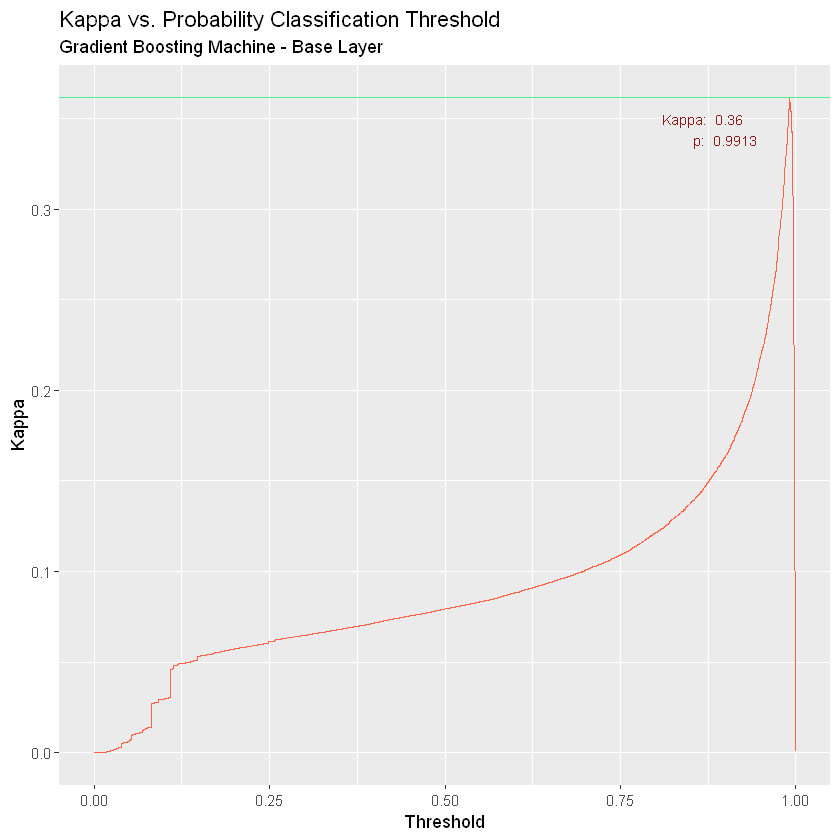

In [534]:
# Visualise relationship between Kappa vs. probability threshold:
ggplot(data=threshold_gbm, aes(x=Threshold, y=Kappa)) +
  geom_line(color="tomato1") + 
  geom_hline(aes(yintercept=max(Kappa)), color="seagreen2")+
  geom_text(aes(x=Threshold[Kappa == max(Kappa)][1], 
                label=paste("Kappa: ",round(max(Kappa), 2),"\np: ",Threshold[Kappa == max(Kappa)][1]), y=max(Kappa)), 
            size = 3, hjust = 1.5, vjust = 1.5, show.legend = FALSE,
            color="firebrick4")+
  labs(title = "Kappa vs. Probability Classification Threshold",
       subtitle = model_name) 

In [535]:
##### PREDICT ON VALIDATION SET USING OPTIMISED PROBABILITY THRESHOLD #####
validation_data$pred_gbm_class_opt <- ifelse(validation_data$pred_gbm_prob_more >= class_threshold_gbm, "more", "less")

# Compare prior probabilities to prediction probabilities:
priors_validation_data <- estimte_prior_probs(labels = validation_data$income) 
post_validation_data <- sum(validation_data$pred_gbm_class_opt == "more")/nrow(validation_data) 
cat(paste0("Prior probs: ",round(priors_validation_data, 4), "\nPrediction probs: ", round(post_validation_data, 4)))

Prior probs: 0.062
Prediction probs: 0.0885

In [536]:
##### PREDICT ON TEST SET USING OPTIMISED PROBABILITY THRESHOLD #####
test_data$pred_gbm_prob_more <- predict(object = model_gbm, newdata = test_data, type = "prob")$more
test_data$pred_gbm_class_opt <- ifelse(test_data$pred_gbm_prob_more >= class_threshold_gbm, "more", "less")

# Compare prior probabilities to prediction probabilities:
priors_test_data <- estimte_prior_probs(labels = test_data$income) 
post_test_data <- sum(test_data$pred_gbm_class_opt == "more")/nrow(test_data) 
cat(paste0("Prior probs: ",round(priors_validation_data, 4), "\nPrediction probs: ", round(post_test_data, 4)))

Prior probs: 0.062
Prediction probs: 0.0861

In [537]:
##### GOOD HOUSEKEEPING #####
# rm(list=setdiff(ls(), c("train_data", "test_data", "validation_data", "control_train", 
#                         "estimte_prior_probs", "classify_predictions", "optimize_threshold",
#                         "plot_numerical_variable", "plot_categorical_variable", "palette",
#                         "proper_case", "outcome_labeller", "outcome_names")))
# ls()

### <font color=purple>MODEL 2: RECURSIVE PARTINIONING AND REGRESSION TREES</font>

In [538]:
model_name <- "Recursive Partioning and Regression Trees - Base Layer"

In [539]:
##### TRAIN MODEL #####
# t1 <- Sys.time()
# model_rpart <- train(income~., data=train_data, method="rpart", trControl=control_train, tuneLength = 10)
# t2 <- Sys.time() 
# t2 - t1 # Time difference of 16.9226 mins
#saveRDS(model_rpart, file = "outputs/model_building/model_rpart.RDS")
model_rpart <- readRDS(file = "outputs/model_building/model_rpart.RDS")

In [540]:
##### PREDICT ON VALIDATION SET #####
# Analyse default classification results (probability threshold = 0.5):
validation_data$pred_rpart_class_raw <- predict(object = model_rpart, newdata = validation_data, type = "raw")
caret::confusionMatrix(validation_data$pred_rpart_class_raw, validation_data$income, positive = "more")
print(postResample(pred = validation_data$pred_rpart_class_raw, obs = validation_data$income)) # 0.7884090 0.2548524

Confusion Matrix and Statistics

          Reference
Prediction  less  more
      less 48520   661
      more 13241  3422
                                         
               Accuracy : 0.7889         
                 95% CI : (0.7857, 0.792)
    No Information Rate : 0.938          
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.2558         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.83811        
            Specificity : 0.78561        
         Pos Pred Value : 0.20537        
         Neg Pred Value : 0.98656        
             Prevalence : 0.06201        
         Detection Rate : 0.05197        
   Detection Prevalence : 0.25307        
      Balanced Accuracy : 0.81186        
                                         
       'Positive' Class : more           
                                         

 Accuracy     Kappa 
0.7888646 0.2557596 


**Significantly better performance than GBM. A 26% higher than random prediction-reference classification agreement.**

In [541]:
##### PROBABILITY THRESHOLD OPTIMISATION #####
# Get prediction probabilities for income == "more":
validation_data$pred_rpart_prob_more <- predict(object = model_rpart, newdata = validation_data, type = "prob")$more

# Optimize classification probability threshold:
t1 <- Sys.time()
threshold_rpart <- optimize_threshold(labels = validation_data$income, probs = validation_data$pred_rpart_prob_more)
t2 <- Sys.time(); t2 - t1 # Time difference of 4.119202 mins

# Select as threshold p where Kappa is max:
class_threshold_rpart <- threshold_rpart$Threshold[threshold_rpart$Kappa == max(threshold_rpart$Kappa)][1]

Time difference of 3.976279 mins

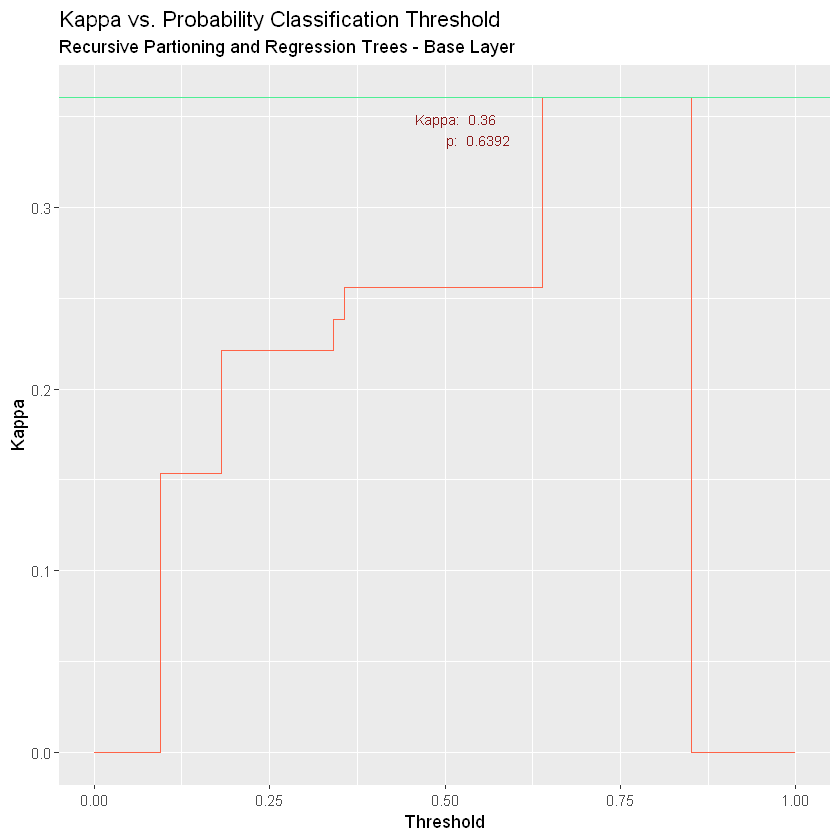

In [542]:
# Visualise relationship between Kappa vs. probability threshold:
ggplot(data=threshold_rpart, aes(x=Threshold, y=Kappa)) +
  geom_line(color="tomato1") + 
  geom_hline(aes(yintercept=max(Kappa)), color="seagreen2")+
  geom_text(aes(x=Threshold[Kappa == max(Kappa)][1], 
                label=paste("Kappa: ",round(max(Kappa), 2),"\np: ",Threshold[Kappa == max(Kappa)][1]), y=max(Kappa)), 
            size = 3, hjust = 1.5, vjust = 1.5, show.legend = FALSE,
            color="firebrick4")+
  labs(title = "Kappa vs. Probability Classification Threshold",
       subtitle = model_name) 

In [543]:
##### PREDICT ON VALIDATION SET USING OPTIMISED PROBABILITY THRESHOLD #####
validation_data$pred_rpart_class_opt <- ifelse(validation_data$pred_rpart_prob_more >= class_threshold_rpart, "more", "less")

# Compare prior probabilities to prediction probabilities:
priors_validation_data <- estimte_prior_probs(labels = validation_data$income) 
post_validation_data <- sum(validation_data$pred_rpart_class_opt == "more")/nrow(validation_data) 
cat(paste0("Prior probs: ",round(priors_validation_data, 4), "\nPrediction probs: ", round(post_validation_data, 4)))

Prior probs: 0.062
Prediction probs: 0.1508

In [544]:
##### PREDICT ON TEST SET USING OPTIMISED PROBABILITY THRESHOLD #####
test_data$pred_rpart_prob_more <- predict(object = model_rpart, newdata = test_data, type = "prob")$more
test_data$pred_rpart_class_opt <- ifelse(test_data$pred_rpart_prob_more >= class_threshold_rpart, "more", "less")

# Compare prior probabilities to prediction probabilities:
priors_test_data <- estimte_prior_probs(labels = test_data$income) # [1] 0.06200248
post_test_data <- sum(test_data$pred_rpart_class_opt == "more")/nrow(test_data) # [1] 0.1514535
cat(paste0("Prior probs: ",round(priors_validation_data, 4), "\nPrediction probs: ", round(post_test_data, 4)))

Prior probs: 0.062
Prediction probs: 0.15

In [545]:
##### GOOD HOUSEKEEPING #####
#rm(list=setdiff(ls(), c("train_data", "test_data", "validation_data", "control_train", 
#                        "estimte_prior_probs", "classify_predictions", "optimize_threshold",
#                        "plot_numerical_variable", "plot_categorical_variable", "palette",
#                        "proper_case", "outcome_labeller", "outcome_names")))
#ls()

### <font color=purple>MODEL 3: BAGGED CART</font>

In [546]:
model_name <- "Bagged Classification and Regression Trees - Base Layer"

In [547]:
##### TRAIN MODEL #####
# t1 <- Sys.time()
# model_cart <- train(income~., data=train_data, method="treebag", trControl=control_train, metric = "Kappa", keep.data = FALSE)
# t2 <- Sys.time() 
# t2 - t1 # Time difference of 29.44355 mins
#saveRDS(model_cart, file = "outputs/model_building/model_cart.RDS")
model_cart <- readRDS(file = "outputs/model_building/model_cart.RDS")

In [548]:
##### PREDICT ON VALIDATION SET #####
# Analyse default classification results (probability threshold = 0.5):
validation_data$pred_cart_class_raw <- predict(object = model_cart, newdata = validation_data, type = "raw")
caret::confusionMatrix(validation_data$pred_cart_class_raw, validation_data$income, positive = "more")
print(postResample(pred = validation_data$pred_cart_class_raw, obs = validation_data$income)) # 0.52572748 0.09963197 

Confusion Matrix and Statistics

          Reference
Prediction  less  more
      less 30635   185
      more 31126  3898
                                          
               Accuracy : 0.5245          
                 95% CI : (0.5206, 0.5283)
    No Information Rate : 0.938           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0993          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.95469         
            Specificity : 0.49602         
         Pos Pred Value : 0.11130         
         Neg Pred Value : 0.99400         
             Prevalence : 0.06201         
         Detection Rate : 0.05920         
   Detection Prevalence : 0.53192         
      Balanced Accuracy : 0.72536         
                                          
       'Positive' Class : more            
                                          

  Accuracy      Kappa 
0.52446692 0.09930899 


**Almost the same performance as GBM. Only 10% higher than random prediction-reference classification agreement.**

In [549]:
##### PROBABILITY THRESHOLD OPTIMISATION #####
# Get prediction probabilities for income == "more":
validation_data$pred_cart_prob_more <- predict(object = model_cart, newdata = validation_data, type = "prob")$more

# Optimize classification probability threshold:
t1 <- Sys.time()
threshold_cart <- optimize_threshold(labels = validation_data$income, probs = validation_data$pred_cart_prob_more)
t2 <- Sys.time(); t2 - t1 # Time difference of 6.164637 mins

# Select as threshold p where Kappa is max:
class_threshold_cart <- threshold_cart$Threshold[threshold_cart$Kappa == max(threshold_cart$Kappa)][1]

Time difference of 4.26711 mins

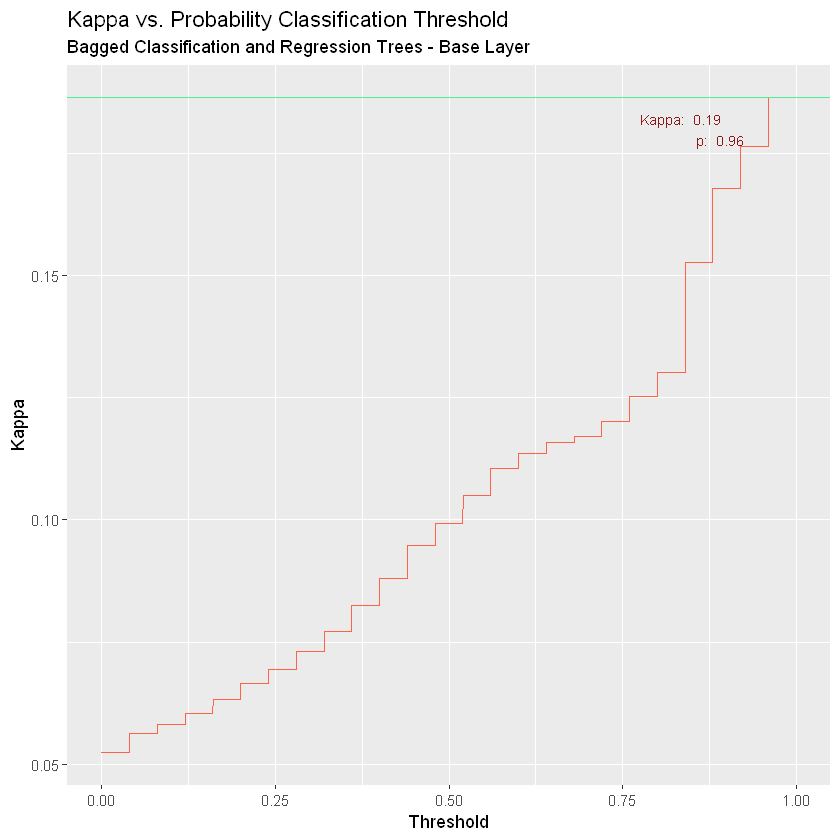

In [550]:
# Visualise relationship between Kappa vs. probability threshold:
ggplot(data=threshold_cart, aes(x=Threshold, y=Kappa)) +
  geom_line(color="tomato1") + 
  geom_hline(aes(yintercept=max(Kappa)), color="seagreen2")+
  geom_text(aes(x=Threshold[Kappa == max(Kappa)][1], 
                label=paste("Kappa: ",round(max(Kappa), 2),"\np: ",Threshold[Kappa == max(Kappa)][1]), y=max(Kappa)), 
            size = 3, hjust = 1.5, vjust = 1.5, show.legend = FALSE,
            color="firebrick4")+
  labs(title = "Kappa vs. Probability Classification Threshold",
       subtitle = model_name) 

In [551]:
##### PREDICT ON VALIDATION SET USING OPTIMISED PROBABILITY THRESHOLD #####
validation_data$pred_cart_class_opt <- ifelse(validation_data$pred_cart_prob_more >= class_threshold_cart, "more", "less")

# Compare prior probabilities to prediction probabilities:
priors_validation_data <- estimte_prior_probs(labels = validation_data$income) # [1] 0.06201021
post_validation_data <- sum(validation_data$pred_cart_class_opt == "more")/nrow(validation_data) # [1] 0.1499301
cat(paste0("Prior probs: ",round(priors_validation_data, 4), "\nPrediction probs: ", round(post_validation_data, 4)))

Prior probs: 0.062
Prediction probs: 0.151

In [552]:
##### PREDICT ON TEST SET USING OPTIMISED PROBABILITY THRESHOLD #####
test_data$pred_cart_prob_more <- predict(object = model_cart, newdata = test_data, type = "prob")$more
test_data$pred_cart_class_opt <- ifelse(test_data$pred_cart_prob_more >= class_threshold_cart, "more", "less")

# Compare prior probabilities to prediction probabilities:
priors_test_data <- estimte_prior_probs(labels = test_data$income)  
post_test_data <- sum(test_data$pred_cart_class_opt == "more")/nrow(test_data)  
cat(paste0("Prior probs: ",round(priors_validation_data, 4), "\nPrediction probs: ", round(post_test_data, 4)))

Prior probs: 0.062
Prediction probs: 0.1506

In [553]:
##### GOOD HOUSEKEEPING #####
#rm(list=setdiff(ls(), c("train_data", "test_data", "validation_data", "control_train", 
#                        "estimte_prior_probs", "classify_predictions", "optimize_threshold",
#                        "plot_numerical_variable", "plot_categorical_variable", "palette",
#                        "proper_case", "outcome_labeller", "outcome_names")))
#ls()

# <font color=blue>5. Model Evaluation</font>
Model evaluation in this project consists of the following tasks:
1. Estimate correlation of base models.
2. Ensamble base models.
3. Train of top layer.
4. Evaluate of final predictions.

### 1. Estimate correlation of base models.

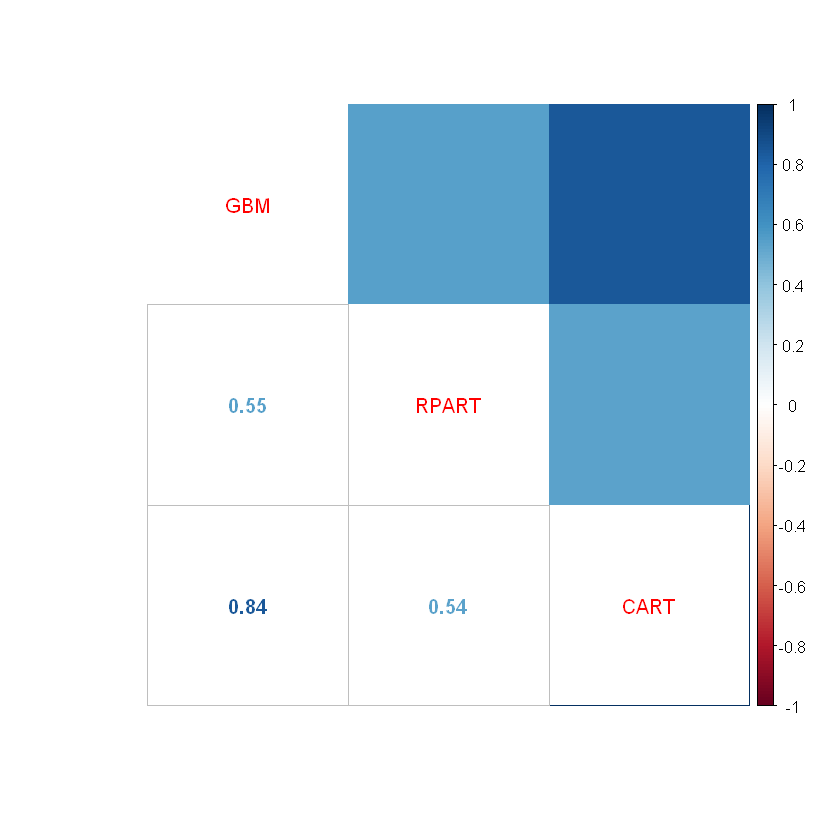

In [554]:
##### SELECT PREDICTED PROBABILITIES FROM BASE MODELS #####
# Get column names from predicted featurs:
prediction_probs_labels <- c("pred_gbm_prob_more", "pred_rpart_prob_more", "pred_cart_prob_more")
# Create dataset with only the predicted probabilities by the base models:
prediction_probs_validation_data <- validation_data[,names(validation_data) %in% prediction_probs_labels]
# Rename columns for better visualisation of correlation plot:
colnames(prediction_probs_validation_data) <- c("GBM", "RPART", "CART")
# Calculate correlations between base models:
correlation_preds_probls_val <- cor(prediction_probs_validation_data)
# Plot correlations:
corrplot.mixed(correlation_preds_probls_val, upper = "color")

## <font color=green>SUMMARY</font>
* A 0.55 correlation between GBM and RPART means models are congruent yet not strongly correlated, making it convenient for stacking them together in an ensemble model.
* Similarly, a 0.54 correlation between RPART and CART bodes well for stacking together.
* However, there is a strong correlation between GBM and CART. Stacking them together in the same ensemble model risks magnifying potential bias shared by both models.
* A task for a future iteration of this project can be to explore some different algorithms (e.g. random forest) for replacing either GBM or CART as part of the base layer, depending on their correlations with the already trained models.

### 2. Ensamble base models.
**Stack predictions from base models to train new classifier composed by only these features.**
## <font color=green>IMPORTANT</font>
**Stacking can be done using either the prediction probabilities from the base models, the prediction classes, both, or even engineered features from them. For this project, only the prediction classes are used to train a top layer using a GBM, which beneath the hood applies one-hot encoding to these factor variables.**

In [555]:
model_name <- "GBM Ensamble Model of GBM, RPART, & Bagged CART"

In [556]:
# Get column names from predicted class features:
prediction_class_labels <- c("pred_gbm_class_opt", "pred_rpart_class_opt", "pred_cart_class_opt")

In [557]:
##### SET HYPERPARAMETER TUNING GRID #####
gbm_grid <- expand.grid(interaction.depth = c(5, 10, 15),
                        n.trees = c(100, 150, 200),
                        shrinkage = c(0.15, 0.1, 0.05),
                        n.minobsinnode = 10)

In [558]:
##### TRAIN TOP LAYER OF ENSEMBLE MODEL #####
# t1 <- Sys.time()
# model_ensemble <- train(income~., data=validation_data[,c(prediction_class_labels, "income")], method="gbm", trControl=control_train, tuneGrid = gbm_grid, metric = "Kappa", keep.data = FALSE)
# t2 <- Sys.time()
# t2- t1 # Time difference of 10.98253 mins
# saveRDS(model_ensemble, file = "outputs/model_building/model_ensemble.RDS")
model_ensemble <- readRDS(file = "outputs/model_building/model_ensemble.RDS")

In [559]:
##### PREDICT ENSEMBLE MODEL ON TEST SET #####
# Analyse default classification results (probability threshold = 0.5):
test_data$pred_ensemble_class_raw <- predict(object = model_ensemble, newdata = test_data, type = "raw")
caret::confusionMatrix(test_data$pred_ensemble_class_raw, test_data$income, positive = "more")
print(postResample(pred = test_data$pred_ensemble_class_raw, obs = test_data$income)) # 0.8530574 0.3478076 

Confusion Matrix and Statistics

          Reference
Prediction  less  more
      less 27136   378
      more  4679  1725
                                          
               Accuracy : 0.8509          
                 95% CI : (0.8471, 0.8547)
    No Information Rate : 0.938           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3443          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.82026         
            Specificity : 0.85293         
         Pos Pred Value : 0.26936         
         Neg Pred Value : 0.98626         
             Prevalence : 0.06200         
         Detection Rate : 0.05086         
   Detection Prevalence : 0.18881         
      Balanced Accuracy : 0.83659         
                                          
       'Positive' Class : more            
                                          

 Accuracy     Kappa 
0.8509051 0.3443428 


**Very good performance. 34% higher than random prediction-reference classification agreement.**

In [560]:
##### PROBABILITY THRESHOLD OPTIMISATION #####
# Get prediction probabilities for income == "more":
test_data$pred_ensemble_prob_more <- predict(object = model_ensemble, newdata = test_data, type = "prob")$more

# Optimize classification probability threshold:
t1 <- Sys.time()
threshold_ensemble <- optimize_threshold(labels = test_data$income, probs = test_data$pred_ensemble_prob_more)
t2 <- Sys.time(); t2 - t1 # Time difference of 2.033221 mins

# Select as threshold p where Kappa is max:
class_threshold_ensemble <- threshold_ensemble$Threshold[threshold_ensemble$Kappa == max(threshold_ensemble$Kappa)][1]

Time difference of 1.980648 mins

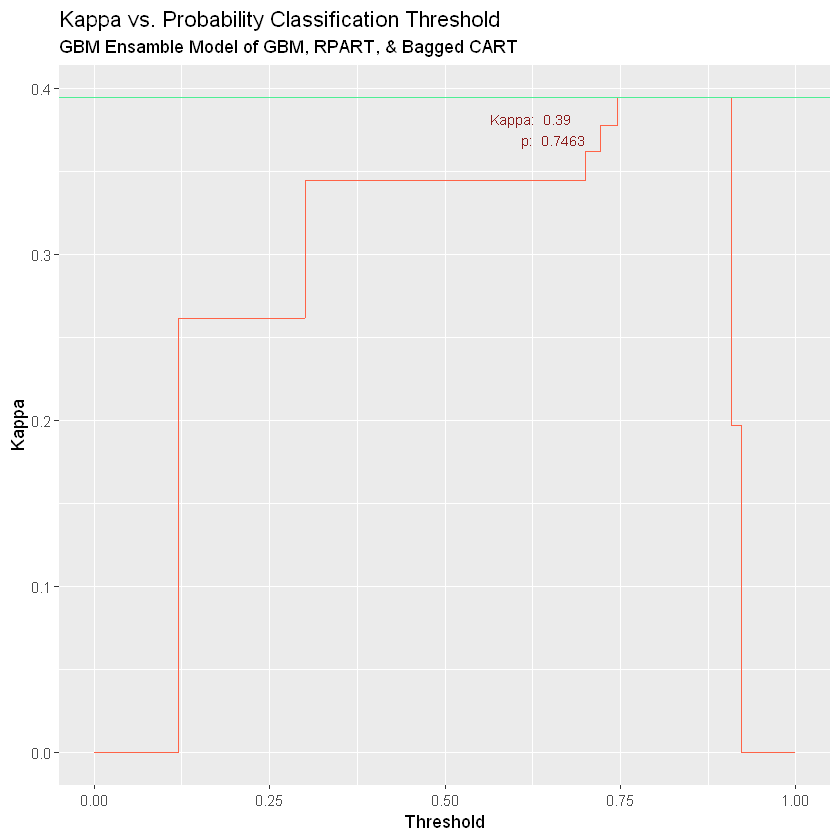

In [561]:
# Visualise relationship between Kappa vs. probability threshold:
ggplot(data=threshold_ensemble, aes(x=Threshold, y=Kappa)) +
  geom_line(color="tomato1") + 
  geom_hline(aes(yintercept=max(Kappa)), color="seagreen2")+
  geom_text(aes(x=Threshold[Kappa == max(Kappa)][1], 
                label=paste("Kappa: ",round(max(Kappa), 2),"\np: ",Threshold[Kappa == max(Kappa)][1]), y=max(Kappa)), 
            size = 3, hjust = 1.5, vjust = 1.5, show.legend = FALSE,
            color="firebrick4")+
  labs(title = "Kappa vs. Probability Classification Threshold",
       subtitle = model_name) 

In [562]:
##### PREDICT ON test SET USING OPTIMISED PROBABILITY THRESHOLD #####
test_data$pred_ensemble_class_opt <- as.factor(ifelse(test_data$pred_ensemble_prob_more >= class_threshold_ensemble, "more", "less"))

# Compare prior probabilities to prediction probabilities:
priors_test_data <- estimte_prior_probs(labels = test_data$income)
post_test_data <- sum(test_data$pred_ensemble_class_opt == "more")/nrow(test_data) 
cat(paste0("Prior probs: ",round(priors_test_data, 4), "\nPrediction probs: ", round(post_test_data, 4)))

Prior probs: 0.062
Prediction probs: 0.0473

In [563]:
##### EVALUATE ENSEMBLE MODEL PERFORMANCE #####
caret::confusionMatrix(test_data$pred_ensemble_class_opt, test_data$income, positive = "more")
print(postResample(pred = test_data$pred_ensemble_class_opt, obs = test_data$income))

Confusion Matrix and Statistics

          Reference
Prediction  less  more
      less 31002  1312
      more   813   791
                                          
               Accuracy : 0.9373          
                 95% CI : (0.9347, 0.9399)
    No Information Rate : 0.938           
    P-Value [Acc > NIR] : 0.6946          
                                          
                  Kappa : 0.3943          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.37613         
            Specificity : 0.97445         
         Pos Pred Value : 0.49314         
         Neg Pred Value : 0.95940         
             Prevalence : 0.06200         
         Detection Rate : 0.02332         
   Detection Prevalence : 0.04729         
      Balanced Accuracy : 0.67529         
                                          
       'Positive' Class : more            
                                          

 Accuracy     Kappa 
0.9373489 0.3942583 


## <font color=green>SUMMARY</font>
* Better performance than any of the base models individually. 
* Ensemble model produces 39% higher than random prediction-reference classification agreement.
* Accuracy of 94% is acceptable for deploying model into production, prior error analysis of misclassified cases.

# <font color=blue>6. Model Deployment</font>

Deployment of this model can be adopted in several ways, not all exclusive. 
<br>
<br>
In the context of the US Census Bureau, the model can be integrated as a process within a larger data pipeline where survey data gets aggregated, where it consumes the relevant variables the model uses as predictors, and predicts the outcome variable "Income" for observations which lack a true value for it. 
<br>
<br>
Furthermore, observations which do have a true value for the variable "Income" can be used to continously measure the model's performance and observe for potential model drift.
<br>
<br>
Last, the model can also de deployed with an exposed endpoint which users can call on demand for particular research and analysis of census data.

# <font color=blue>7. Business Insights</font>

To infer which features seem to be most influential in determining whether an individual earns more or less than USD 50k, an analysis of variable importance is conducted side-by-side with an analysis of the most important variables' conditional distribution vis-a-vis income.

gbm variable importance

  only 20 most important variables shown (out of 21)

                                    Overall
weeks_worked_in_year              100.00000
detailed_occupation_recode         49.24074
education                          36.37357
age                                25.83578
sex                                10.23957
capital_gains                       6.61573
tax_filer_stat                      6.42132
class_of_worker                     5.85428
detailed_industry_recode            5.76597
num_persons_worked_for_employer     4.57130
dividends_from_stocks               3.49818
capital_losses                      1.31700
marital_stat                        1.11516
country_of_birth_mother             0.87076
wage_per_hour                       0.86925
full_or_part_time_employment_stat   0.62249
own_business_or_self_employed       0.34695
race                                0.26989
citizenship                         0.19623
hispanic_origin                     0.074

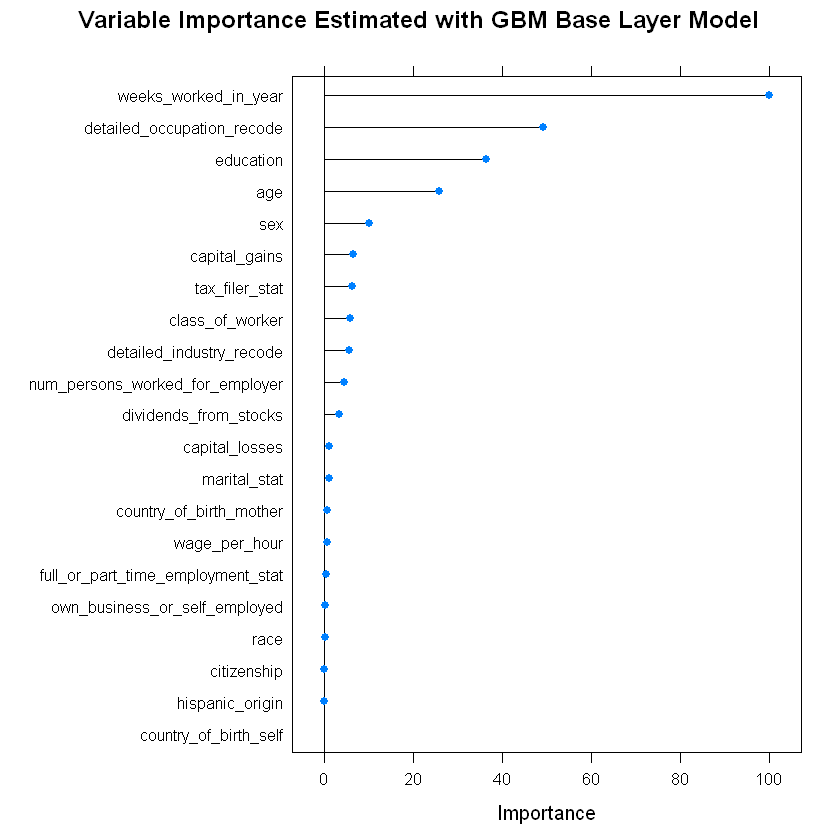

In [564]:
##### FEATURE INSIGHTS FROM GBM BASE LAYER MODEL #####
var_imp_gbm <- varImp(model_gbm, scale=TRUE)
print(var_imp_gbm)
plot(var_imp_gbm, main = "Variable Importance Estimated with GBM Base Layer Model")

## <font color=green>SUMMARY</font>
* The GBM model gives the top predictive power for incomes > USD 50k to the feature "weeks_worked_in_year". 
* The second most predictive feature, with only half of the relative importance of the top feature (49.24/100), is the feature "detailed_occupation_recode".
* Features "education" and "age" play an important role in predicting income, although with a third and a quarter of relative importance, respectively, in relationship with the top feature "weeks_worked_in_year".
* In general, GBM appears to be sensitiv to several of the demographic variables in the dataset.

rpart variable importance

  only 20 most important variables shown (out of 21)

                                  Overall
age                               100.000
weeks_worked_in_year               91.644
num_persons_worked_for_employer    74.760
class_of_worker                    70.941
tax_filer_stat                     65.410
detailed_occupation_recode         44.806
education                          41.964
sex                                24.525
detailed_industry_recode           15.235
capital_gains                       4.622
full_or_part_time_employment_stat   0.000
hispanic_origin                     0.000
own_business_or_self_employed       0.000
marital_stat                        0.000
dividends_from_stocks               0.000
race                                0.000
wage_per_hour                       0.000
country_of_birth_self               0.000
country_of_birth_mother             0.000
citizenship                         0.000


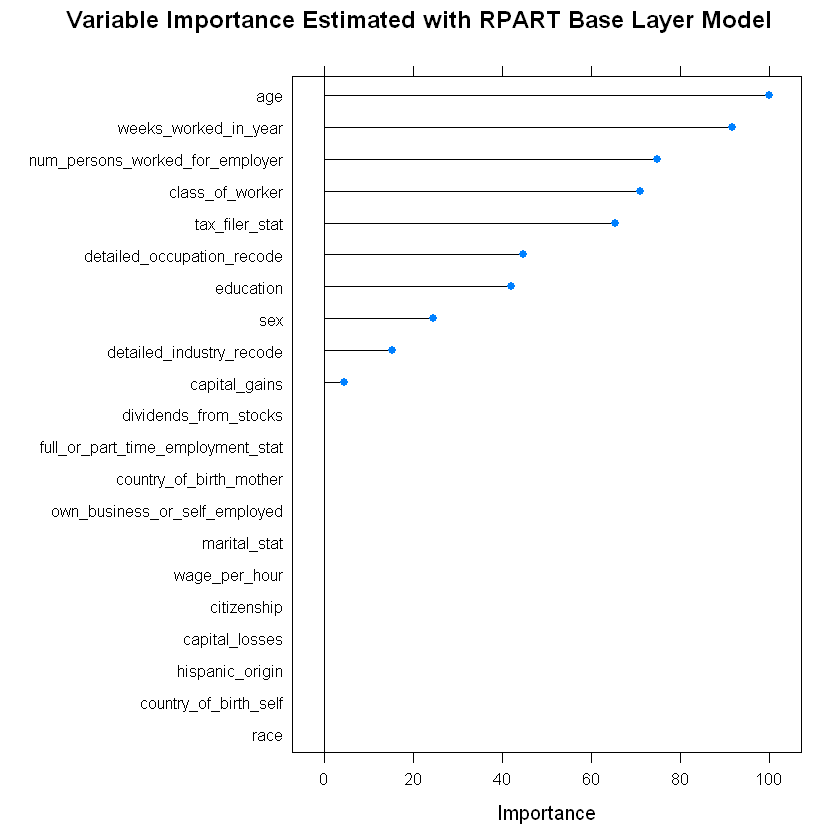

In [565]:
##### FEATURE INSIGHTS FROM RPART BASE LAYER MODEL #####
var_imp_rpart <- varImp(model_rpart, scale=TRUE)
print(var_imp_rpart)
plot(var_imp_rpart, main = "Variable Importance Estimated with RPART Base Layer Model")

## <font color=green>SUMMARY</font>
* The RPART model gives the top predictive power for incomes > USD 50k to the feature "age", with "weeks_worked_in_year" almost as important. 
* RPART assigns to third, fourth, and fifth most predictive features to "num_persons_worked_for_employer", "class_of_worker", and "tax_filer_stat", all with a relative importance of about two thirds of the importance of the top feature "age".
* In general, RPART appears to favour the features from the employment surveys, and its sensitivity is evenly spread among the top features, unlike GBM, which is heavily biased towards its single top feature "weeks_worked_in_year".

treebag variable importance

  only 20 most important variables shown (out of 21)

                                    Overall
age                               100.00000
weeks_worked_in_year               59.77665
num_persons_worked_for_employer    57.55645
class_of_worker                    54.84637
detailed_occupation_recode         54.03859
tax_filer_stat                     50.31946
education                          49.33015
detailed_industry_recode           36.80341
sex                                22.64260
capital_gains                      14.67450
marital_stat                       10.70033
full_or_part_time_employment_stat   6.34764
country_of_birth_mother             4.95026
dividends_from_stocks               3.48565
own_business_or_self_employed       2.38075
race                                1.66472
wage_per_hour                       1.33984
country_of_birth_self               1.10315
capital_losses                      0.44805
hispanic_origin                     0

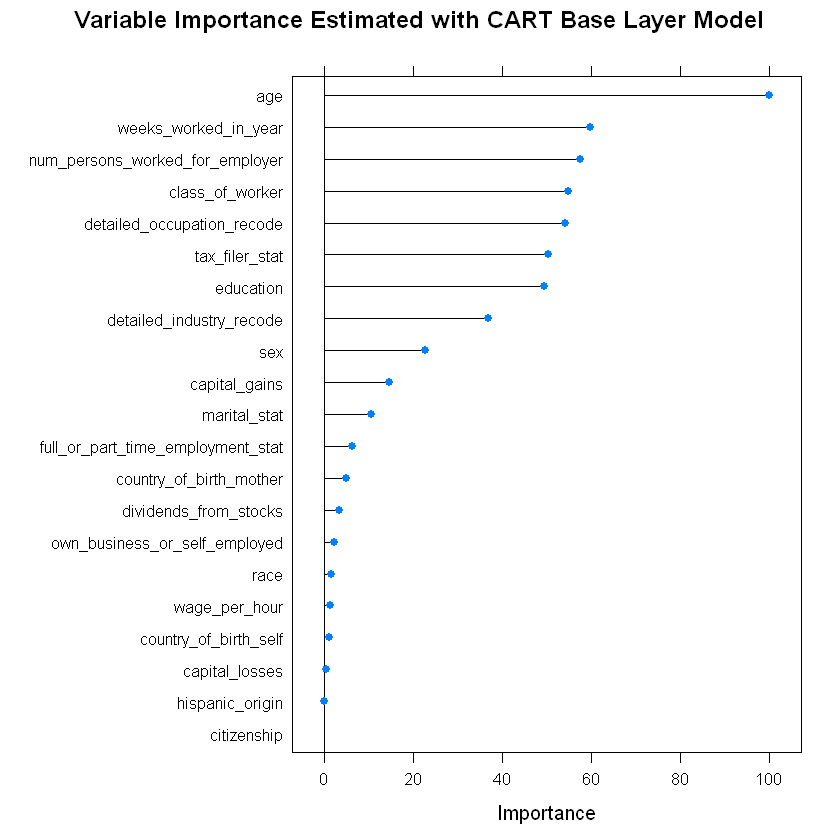

In [566]:
##### FEATURE INSIGHTS FROM CART BASE LAYER MODEL #####
var_imp_cart <- varImp(model_cart, scale=TRUE)
print(var_imp_cart)
plot(var_imp_cart, main = "Variable Importance Estimated with CART Base Layer Model")

## <font color=green>SUMMARY</font>
* The CART model also gives the top predictive power for incomes > USD 50k to the feature "age".
* The feature "weeks_worked_in_year" also comes in second in CART, but unlike RPART, at a little under two-thirds of the relative importance of age.
* CART also assigns to third, fourth, and _sixth_ most predictive features to "num_persons_worked_for_employer", "class_of_worker", and "tax_filer_stat", all with a relative importance of about half of the importance of the top feature "age". It also ranks "detailed_occupation_recode" and "education" in that range of relative importance, at fifth and seventh place.
* In general, feature importance with CART appears to be evenly distributed between demographic and employment variables, as well as distributing the relative importance of features across many variables.

                             FEATURE        AGGR
21              weeks_worked_in_year 83.80702788
1                                age 75.27859282
9         detailed_occupation_recode 49.36186059
15   num_persons_worked_for_employer 45.62908341
5                    class_of_worker 43.88065879
11                         education 42.55586533
19                    tax_filer_stat 40.71690808
8           detailed_industry_recode 19.26800736
18                               sex 19.13562860
2                      capital_gains  8.63738707
14                      marital_stat  3.93849725
10             dividends_from_stocks  2.32794172
12 full_or_part_time_employment_stat  2.32337780
6            country_of_birth_mother  1.94034040
16     own_business_or_self_employed  0.90923307
20                     wage_per_hour  0.73636298
17                              race  0.64486899
3                     capital_losses  0.58835001
7              country_of_birth_self  0.36771545
4                   

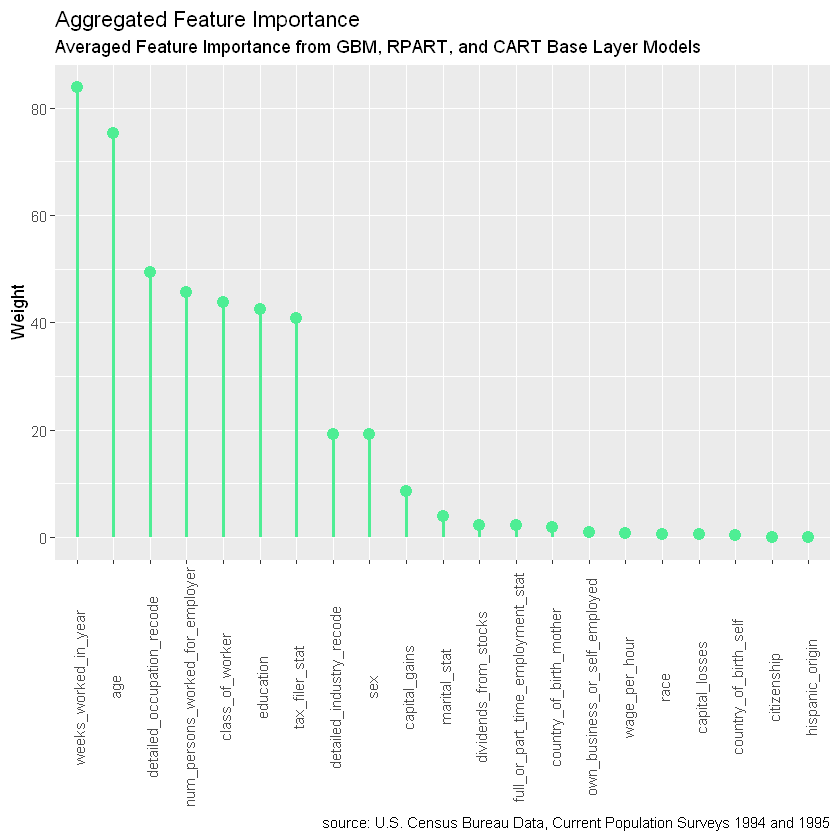

In [567]:
##### AGGREGATE FEATURE IMPORTANCE #####
var_names <- unique(c(row.names(var_imp_gbm$importance), row.names(var_imp_rpart$importance), row.names(var_imp_cart$importance)))
var_imp_gbm_df <- data.frame(FEATURE = row.names(var_imp_gbm$importance), GBM = var_imp_gbm$importance$Overall, stringsAsFactors = FALSE)
var_imp_rpart_df <- data.frame(FEATURE = row.names(var_imp_rpart$importance), RPART = var_imp_rpart$importance$Overall, stringsAsFactors = FALSE)
var_imp_cart_df <- data.frame(FEATURE = row.names(var_imp_cart$importance), CART = var_imp_cart$importance$Overall, stringsAsFactors = FALSE)
var_imp_aggr <- merge(var_imp_gbm_df, var_imp_rpart_df, by = "FEATURE")
var_imp_aggr <- merge(var_imp_aggr, var_imp_cart_df, by = "FEATURE")

#var_imp_gbm$importance, var_imp_rpart$importance, var_imp_cart$importance)
var_imp_aggr$AGGR <- rowMeans(var_imp_aggr[,2:4])
var_imp_aggr <- var_imp_aggr[order(-var_imp_aggr$AGGR),]
print(var_imp_aggr[,c("FEATURE", "AGGR")])
# Plot feature importance:
ggplot(var_imp_aggr, aes(x=reorder(FEATURE, -AGGR), y= AGGR)) + 
  geom_point(size=3, color = "seagreen2") + 
  geom_segment(aes(x=FEATURE, 
                   xend=FEATURE, 
                   y=0, 
                   yend=AGGR),
               size = 1,
               color = "seagreen2") + 
  labs(title="Aggregated Feature Importance", 
       subtitle="Averaged Feature Importance from GBM, RPART, and CART Base Layer Models",
       caption = "source: U.S. Census Bureau Data, Current Population Surveys 1994 and 1995") + 
  theme(axis.text.x = element_text(angle=90, vjust=0.6),  axis.title.x=element_blank()) +
  ylab("Weight")

In [568]:
##### CONDITIONAL DISTRIBUTION OF TOP-N FEATURES #####
copy_of_train_data <- readRDS(file = "data/train_data_factors_na_removed.RDS") 
#top_n_features <- 7
#for(i in var_imp_aggr$FEATURE[1:top_n_features]){
#  var_class <- class(copy_of_train_data[,names(copy_of_train_data) == i])
#  if(var_class == "integer"){
#    print(plot_numerical_variable(variable = i, dataset = copy_of_train_data, colour = sample(palette, 1), set_type = "Training Set"))
#  } else if(var_class == "factor") {
#    suppressWarnings(print(plot_categorical_variable(variable = i, dataset = copy_of_train_data, colour = sample(palette, 1), set_type = "Training Set", n = 9)))
#  }
#}

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


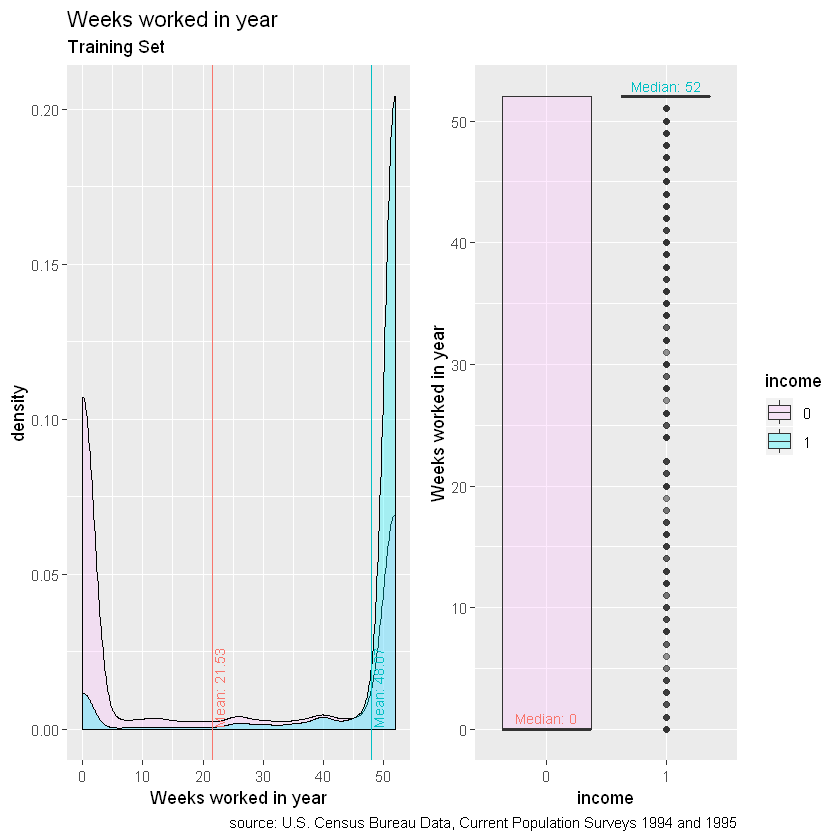

In [569]:
print(plot_numerical_variable(variable = "weeks_worked_in_year", dataset = copy_of_train_data, colour = sample(palette, 1), set_type = "Training Set"))

## <font color=green>SUMMARY</font>
* For people who make < USD 50k there's a bimodal distribution with regards to the number of weeks they work in a year. The higher mode is towards 0 days, while the second mode is towards 52.
* On the other side, almost every person who makes > USD 50k works 52 weeks per year. Only outliers lie beneath the 52-weeks-a-year mark.
* This means that working all year long is necessary (disregarding the outliers) for high income, but not sufficient, as a significant portion of people work all year but still earn below the USD 50k.

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


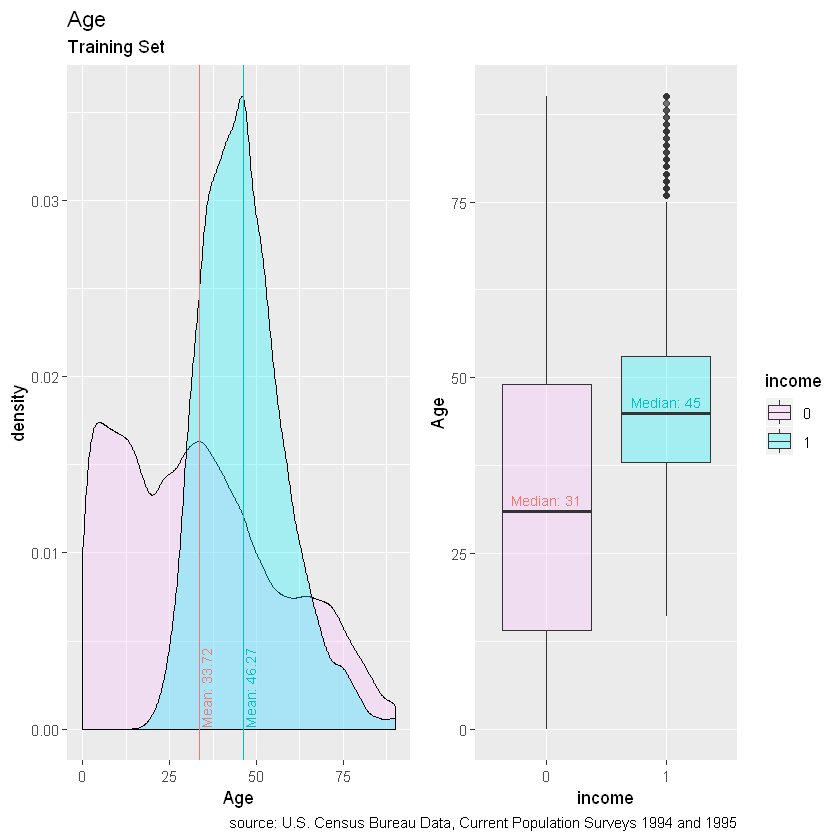

In [570]:
print(plot_numerical_variable(variable = "age", dataset = copy_of_train_data, colour = sample(palette, 1), set_type = "Training Set"))

## <font color=green>SUMMARY</font>
* Once again, for people earning < USD 50k there's a bimodal distribution with regards to age. The left most peak represents the portion of the population underaged (children), while the second peak represents adults in their working prime years (~33).
* For people making > USD 50k, the distribution is fairly symmetric and with short tails, centered at ~45 years of age.
* Towards the elderly years, the density of the < USD 50k is larger than the > USD 50k. This suggests several hypothesis:
    * Declining incomes as people get older.
    * Generational transfers of wealth (e.g. changes in welfare policies).
    * Distinct generations riding different stages of the long-term business cycle (booms and busts affecting generations in their prime years differently). 

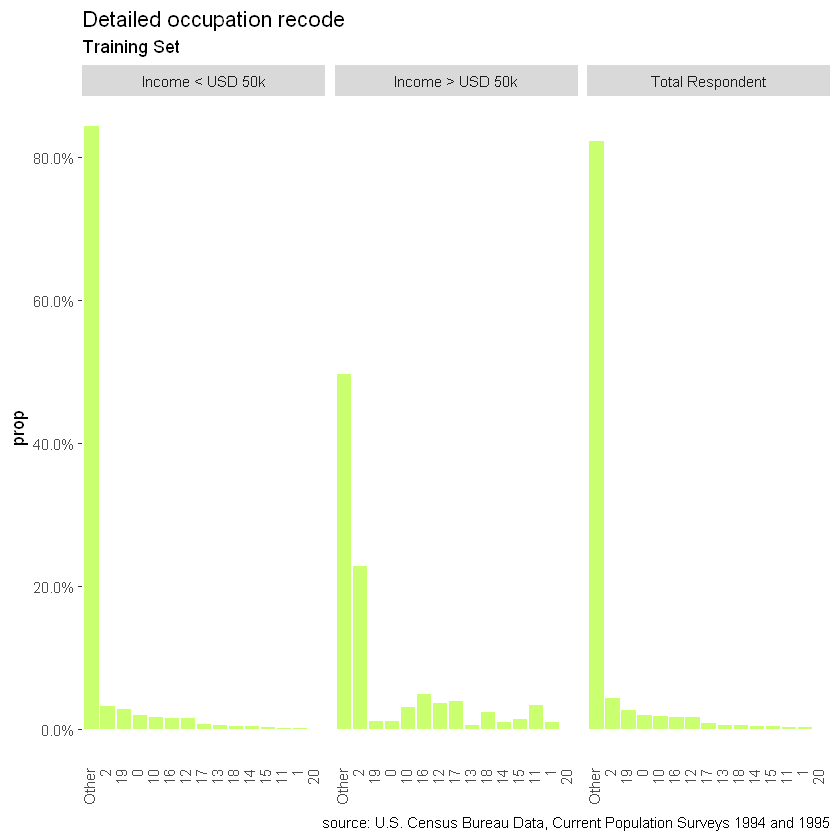

In [571]:
suppressWarnings(print(plot_categorical_variable(variable = "detailed_occupation_recode", dataset = copy_of_train_data, colour = sample(palette, 1), set_type = "Training Set", n = 14)))

## <font color=green>SUMMARY</font>
* The main occupation predicting incomes > USD 50k is "Executive admin and managerial" (code 2), representing more than 20% of high-earning individuals.
* Other occupations which also predict high incomes, although at a lesser degree, are:
    * Sales (codes 16, 17, and 18)
    * Professional services (code 11)

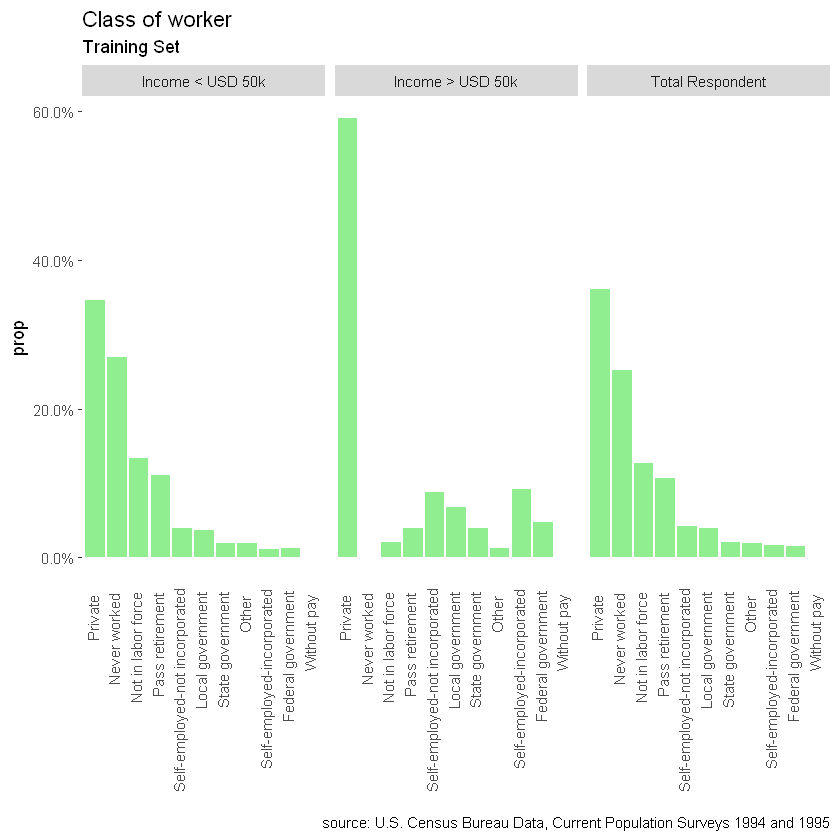

In [572]:
suppressWarnings(print(plot_categorical_variable(variable = "class_of_worker", dataset = copy_of_train_data, colour = sample(palette, 1), set_type = "Training Set", n = 14)))

## <font color=green>SUMMARY</font>
* Almost three-quarters of individuals earning > USD 50k belong to the private sector, including those self-employed.
* However, almost a third of people earning < USD 50k also work in the private sector, making it also a (relatively) necessary condition, but not sufficient for determining high incomes.
* Among individuals with high incomes, all work (no "never worked"), and very few are outside of the labour force.

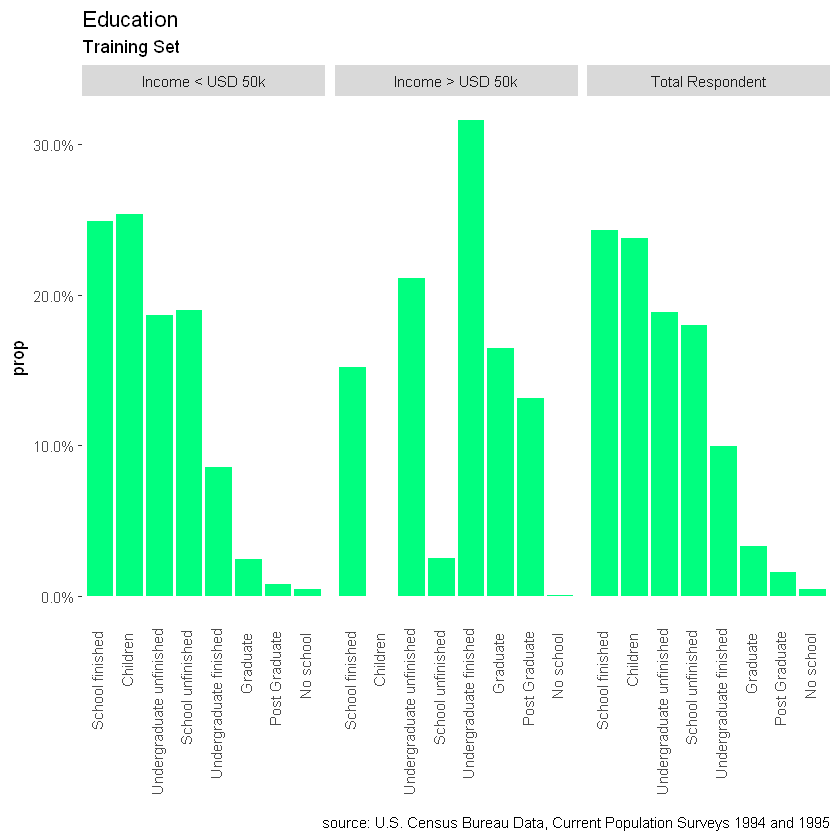

In [573]:
suppressWarnings(print(plot_categorical_variable(variable = "education", dataset = copy_of_train_data, colour = sample(palette, 1), set_type = "Training Set", n = 14)))

## <font color=green>SUMMARY</font>
* With regards to education, any university degree is a predictor of higher incomes.
* A third of all individuals earning > USD 50k have finished an undergraduate degree, while only 10% of lower incomes individuals completed them.
* It is thus that a graduate and postgraduate degree is a far stronger predictor for higher incomes than an undergraduate degree.

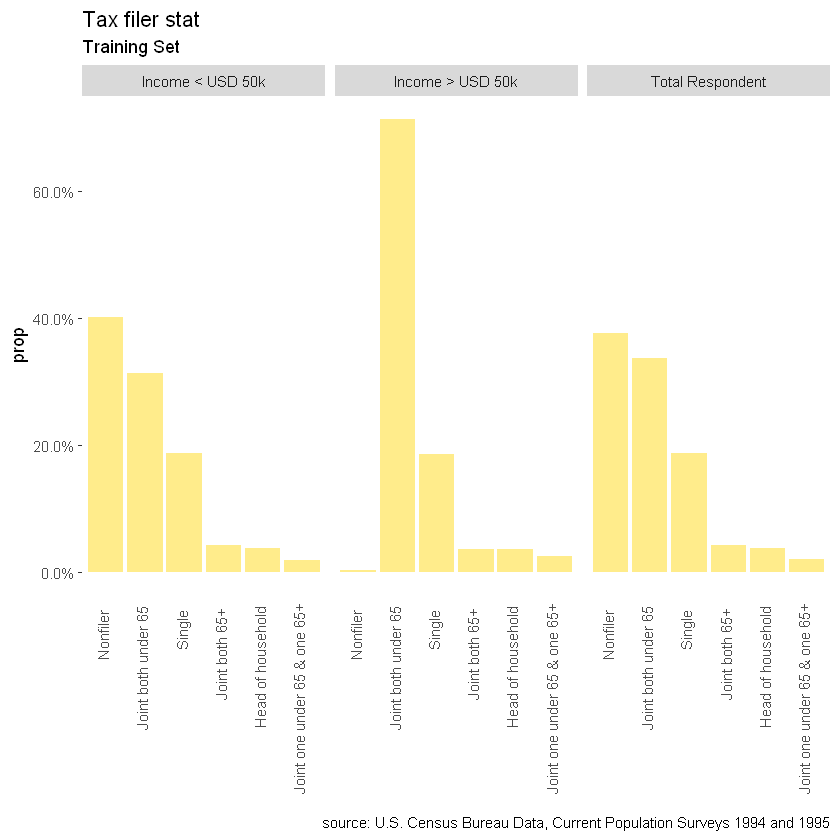

In [574]:
suppressWarnings(print(plot_categorical_variable(variable = "tax_filer_stat", dataset = copy_of_train_data, colour = sample(palette, 1), set_type = "Training Set", n = 14)))

## <font color=green>SUMMARY</font>
* The strongest predicter of high incomes with regards to an individual's tax filing status is that almost none of them are nonfilers.
* Additionally, three-quarters of high income individuals are classified as "Joint both under 65", compared to less than a third of lower income individuals
* Conversely, 40% of individuals earning < USD 50k are classified as non-filers.
* It's important to note that the tax filer status is a lagging indicator of income, not a driver. That is, it helps to predict the previous income of an individual, but has no direct effect of determining the future income of an individual.

# <font color=blue>8. Conclusions</font>

## <font color=green>IMPROVEMENTS</font>
There are many improvement opportunities for this project. Far more than listed below. These are just some examples of the many low-hanging fruit improvements which can be implemented, which have potential to improve model performance:
* There are opportunities for refactoring the code and making it more efficient.
* Instead of WOE, apply one-hot encoding, filter (reduce number of features) with Information Value, and then estimate variable importance.
* Alternatively, apply PCA to reduce the number of original variables and minimize multicolinearity, eliminating the need for estimating correlation between predictor variables.
* Additionally, Factor Analysis can be applied to add a few new features which pick up on patterns of shared variance between the original variables.
* Normalize and scale remaining variables which have not been transformed with WOE (i.e. age, wage_per_hour, num_persons_worked_for_employer, and weeks_worked_in_year).
* For dealing with the unbalanced class problem, several approaches can be tested and compared to: i) no under/over sampling, and ii) SMOTE, such as:
    * Outlier detection
    * Anomaly detection
    * Resampling the training set into a set of multiple balanced sets, running an ensemble of classifiers.
* Using a GLM model for measuring variable importance would not only produce insights regarding which variables are more predictive of an individual's income being above USD 50k, but would also provide insights in the nature of the relationship. That is, it could also show if the relationship of proportional or inverse.
* Reducing the size of models in order to store and validate reproducibility of code. Particularly, the CART model had an initial size of close to 1GB. This was the result of i) caret making copies of the data (and depending on the model, of additional information), and ii) the underlying model package would also save a copy of the data. By modifying these data stoage parameters, model sizes were reduced to less than a third of original size, but still remain quiet large, particularly CART.

## <font color=green>CHALLENGES</font>
The main challenges I faced during this project were:
* For the last two years my focus has been on Natural Language Processing, so I had to get re-familiarised with most of the algorithms tried and implemented in this project. This meant re-reading most of the caret package documentation, and the documentation of some of caret's underlying libraries (e.g. package gbm).
* Lack of computing power for hyperparameter tunning forced me to do multiple iterative small grid searches on each of the base layer algorithms to get a feeling of which set of parameters best helped the algorithms adapt to this data. This was significantly time consuming and prone to error.
* Related to the point above, I wanted to use random forest as one of the base layer algorithms. However, my personal computer crashed everytime I trained it, even with no hyperparameter tuning, and allowing the algorithm to keep all of its default parameters, such as keep.forest = TRUE, which I wanted to change to FALSE to keep the size of the model relatively small for sharing.

## <font color=green>IDEAS FOR THE FUTURE</font>
Doing research on the US Census Bureau and the business applications of survey data, I came across some interesting studies. One in particularly, stated that success of students at certain tertiary education programs was positively influenced by the presence of a foreign father and native born (in the US) mother. The subjective interpretation of this effect had to do with the foreign father instilling a strong sense of work ethic in his children, and the mother providing the native tongue.
This model could be used to some degree to replicate or challenge the results of that study, and further identify which other cultural, economic, and geographic variables can improve the chances of children to do well in their education, and subsequently in their professional endeavours.

_**This project was carried out by Francis Beeson (leobeeson@gmail.com)**_ 

_**Please feel free to comment or reach out if you find something wrong, an inconsistency, or want to suggest an improvement. Always happy to make things better.**_